### Aim: Predicting mortality of ICU patients (The PhysioNet Computing in Cardiology Challenge 2012)

This Jupyter notebook implements the Physionet challenge (https://physionet.org/content/challenge-2012/1.0.0/) to predict mortality of 4000 ICU patients using data collected at time of admission (general descriptors) and over 48 hours on patients (acute physiological descriptors).

A final model is presented using 18 predictors - and its performance is shown to be better than a "benchmark" logistic regression model generated using currently standard measuress of mortality (eg: SOFA/SAPS-1 scores).

**Note on running this notebook**: *To run the notebook, ensure you save needed data files ("seta.csv" and "outcomes.csv" provided as separate attachments within email containing this notebook) to the working directory containing this notebook.* 

In [1]:
#import libraries as may be needed
import numpy as np
import pandas as pd
import datetime

import seaborn as sns
sns.set_style("white")

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 

import warnings
warnings.filterwarnings('ignore')

**1. Import data, inspect for further processing needed**

In [2]:
#Read-in dataset and inspect
df=pd.read_csv("seta_data.csv")
df.head(10)

,PATIENT_ID,Parameter,Time,Value
0,132539,RecordID,00:00,132539.00
1,132539,Age,00:00,54.00
2,132539,Gender,00:00,0.00
3,132539,Height,00:00,-1.00
4,132539,ICUType,00:00,4.00
5,132539,Weight,00:00,-1.00
6,132539,GCS,00:07,15.00
7,132539,HR,00:07,73.00
8,132539,NIDiasABP,00:07,65.00
9,132539,NIMAP,00:07,92.33


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1757980 entries, 0 to 1757979
Data columns (total 4 columns):
PATIENT_ID    int64
Parameter     object
Time          object
Value         float64
dtypes: float64(1), int64(1), object(2)
memory usage: 53.6+ MB


In [4]:
#Convert df to "wide" format
data=pd.pivot_table(df, index=["PATIENT_ID"], columns=["Parameter", "Time"],values=["Value"])

In [5]:
data.head() #Inspect dataframe

Value                                                        ...   \
Parameter    ALP                                                        ...    
Time       00:00 00:01 00:02 00:03 00:04 00:05 00:07 00:08 00:09 00:10  ...    
PATIENT_ID                                                              ...    
132539       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
132540       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
132541       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
132543       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
132545       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    

                                                                        
Parameter     pH                                                        
Time       47:51 47:52 47:53 47:54 47:55 47:56 47:57 47:58 47:59 48:00  
PATIENT_ID                                                              
132539       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
132540       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
132541       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
132543       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
132545       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 92948 columns]

In [6]:
data.columns

MultiIndex(levels=[['Value'], ['ALP', 'ALT', 'AST', 'Age', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Gender', 'Glucose', 'HCO3', 'HCT', 'HR', 'Height', 'ICUType', 'K', 'Lactate', 'MAP', 'MechVent', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RecordID', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight', 'pH'], ['00:00', '00:01', '00:02', '00:03', '00:04', '00:05', '00:06', '00:07', '00:08', '00:09', '00:10', '00:11', '00:12', '00:13', '00:14', '00:15', '00:16', '00:17', '00:18', '00:19', '00:20', '00:21', '00:22', '00:23', '00:24', '00:25', '00:26', '00:27', '00:28', '00:29', '00:30', '00:31', '00:32', '00:33', '00:34', '00:35', '00:36', '00:37', '00:38', '00:39', '00:40', '00:41', '00:42', '00:43', '00:44', '00:45', '00:46', '00:47', '00:48', '00:49', '00:50', '00:51', '00:52', '00:53', '00:54', '00:55', '00:56', '00:57', '00:58', '00:59', '01:00', '01:01', '01:02', '01:

Above data has:
- 5 features/metrics recorded at admission and usually not again *("Age", "Gender", "Height", "ICUType", "RecordID")* and<br>
- 37 features recorded potentially multiple times over a time-course of 48 hours *("Weight",'ALP', 'ALT', 'AST', 'Albumin', 'BUN', 
'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR','K', 'Lactate', 'MAP', 
'MechVent', 'Mg', 'NIDiasABP', 'NIMAP','NISysABP', 'Na','PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp',
'TroponinI', 'TroponinT','Urine', 'WBC', 'pH')*

For sake of simplicity and going forward in this notebook, I will refer to the first 5 features as non-time-series (nts) features and the rest as time-series(ts) features.

**2. Extract non-time-series features into a dataframe along with patient_IDs**

Select non-time series data, inspect and generate a plan/outline on how features are to be extracted. After feature extraction, resulting dataframe is exported as a csv file.

In [7]:
nts = data.filter(regex='RecordID|Age|Gender|Height|ICUType') # Select features within non-time series data as a dataframe

In [8]:
nts.columns=nts.columns.get_level_values(1) # Choose appropriate column "level" for storage as column names

In [9]:
nts.index.get_level_values(0) #Inspect row indexes

Int64Index([132539, 132540, 132541, 132543, 132545, 132547, 132548, 132551,
            132554, 132555,
            ...
            142655, 142659, 142661, 142662, 142664, 142665, 142667, 142670,
            142671, 142673],
           dtype='int64', name='PATIENT_ID', length=4000)

In [10]:
nts.head() # Inspect non-time-series dataframe

Parameter,Age,Gender,Height,ICUType,RecordID
PATIENT_ID,,,,,
132539,54.0,0.0,-1.0,4.0,132539.0
132540,76.0,1.0,175.3,2.0,132540.0
132541,44.0,0.0,-1.0,3.0,132541.0
132543,68.0,1.0,180.3,3.0,132543.0
132545,88.0,0.0,-1.0,3.0,132545.0


In [11]:
nts.describe(percentiles=[0.1, 0.2,0.25, 0.3, 0.4,0.45,  0.5, 0.9]).T  # Inspect feature distributions within dataframe

,count,mean,std,min,10%,20%,25%,30%,40%,45%,50%,90%,max
Parameter,,,,,,,,,,,,,
Age,4000.0,64.247500,17.560946,15.0,40.0,49.0,52.75,56.0,61.0,64.00,67.0,85.0,90.0
Gender,4000.0,0.560750,0.497867,-1.0,0.0,0.0,0.00,0.0,0.0,1.00,1.0,1.0,1.0
Height,4000.0,88.919475,86.531203,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.00,152.4,180.3,431.8
ICUType,4000.0,2.760000,1.002572,1.0,1.0,2.0,2.00,2.0,3.0,3.00,3.0,4.0,4.0
RecordID,4000.0,137605.122000,2923.608886,132539.0,133560.9,134586.6,135075.75,135553.6,136592.8,137105.55,137592.5,141667.2,142673.0


In [12]:
nts.info() #Inspect feature types within dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 132539 to 142673
Data columns (total 5 columns):
Age         4000 non-null float64
Gender      4000 non-null float64
Height      4000 non-null float64
ICUType     4000 non-null float64
RecordID    4000 non-null float64
dtypes: float64(5)
memory usage: 187.5 KB


**Notes/Plan for non-time-series data feature extraction**:<br>
A. Height and Gender entries seem to have entry errors (and will be adjusted next):
   1. Gender should be 0(female) or 1(male). I will reset those with -1 values to a "missing" value.
   2. For "Height", I will cap these to less than 50%ile value of 152.4 cms.
   3. For Age, I will make no adjustment even though the minimum value reported is 15 (patients are disclosed as adults).
    
B. ICUType & Gender are numeric feature. For modeling purposes, I will convert them to categorical features.

C. Categorical features will be one-hot-encoded and concatenated with numeric features. Resultant dataset will be exported as a csv file

In [13]:
#Imputation/value-capping of Height and Gender 
nts['Gender'] = np.where(nts['Gender'] == -1, "missing", nts['Gender']) 
nts['Height'] = np.where(nts['Height'] < 152.4 ,145, nts['Height']) # capped at <50%ile of distribution

#Convert ICU type & Gender to categorical features
nts["ICUType"]=nts["ICUType"].astype("category")
nts["Gender"]=nts["Gender"].astype("category")

In [14]:
# Process nts dataframe for one-hot encoding of categorical variables followed by merge of numeric variables

# Create dataframe of only numeric columns in nts dataframe
numeric_cols=["RecordID", "Height", "Age"]
nts_num=nts[numeric_cols]

# Create dataframe containing dummy versions for categorical variables in bd dataframe
cols_for_dummies=["ICUType", "Gender"]
nts_cat=nts[cols_for_dummies]
nts_dum=pd.get_dummies(nts_cat)

# Assemble numerical and one-hot encoded columns
ntsf=pd.concat([nts_num, nts_dum], axis=1)
ntsf.head()

,RecordID,Height,Age,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0,Gender_0.0,Gender_1.0,Gender_missing
PATIENT_ID,,,,,,,,,,
132539,132539.0,145.0,54.0,0,0,0,1,1,0,0
132540,132540.0,175.3,76.0,0,1,0,0,0,1,0
132541,132541.0,145.0,44.0,0,0,1,0,1,0,0
132543,132543.0,180.3,68.0,0,0,1,0,0,1,0
132545,132545.0,145.0,88.0,0,0,1,0,1,0,0


In [15]:
ntsf.loc[:, ntsf.columns]=ntsf.loc[:, ntsf.columns].apply(pd.to_numeric) #Convert all featurese to numeric after one-hot encoding
ntsf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 132539 to 142673
Data columns (total 10 columns):
RecordID          4000 non-null float64
Height            4000 non-null float64
Age               4000 non-null float64
ICUType_1.0       4000 non-null uint8
ICUType_2.0       4000 non-null uint8
ICUType_3.0       4000 non-null uint8
ICUType_4.0       4000 non-null uint8
Gender_0.0        4000 non-null uint8
Gender_1.0        4000 non-null uint8
Gender_missing    4000 non-null uint8
dtypes: float64(3), uint8(7)
memory usage: 152.3 KB


In [16]:
ntsf.to_csv("nts.csv") # export features extracted from non-time-series data. 
#To be merged subsequently with features extracted with time-series data (X matrix for modeling) and 
#outcome variables (Y) of interest

### 3. Extract time-series features into a dataframe along with patient_IDs

As described above, there are 37 features within time-series data. Per associated documentation of this dataset (https://physionet.org/content/challenge-2012/1.0.0/), these time-series features may be observed for each patient - once, multiple times, or not at all. 

Thus, to extract these features, the following plan will be used:

**Plan**:

1.  For numeric features - minimum value (min), maximum value (max), median value (median), change/range observed (max-min) observed for each patient will be generated. 

    - Entry errors may need to be corrected and this will be evaluated per feature via visualization of their feature distributions (for min, max, median, and change).

    - Where patient values are absent for a feature, I will perform imputation using median. Median imputation is a better measure of the central tendency of skewed distributions and hence I will choose median over mean imputation.
    

2. For categorical features, counts/patient will be generated.


After extraction of time series features, resulting dataframe is exported as a csv file (and will be merged eventually with non-time series data for generation of a predictor matrix/X matrix for modeling purposes).

As a first step for this plan, multi-level columns will be squashed and the entire set of time-series features selected for further processing/feature extraction. 

In [17]:
#Squash multi-level columns
data.columns=data.columns.get_level_values(1)+data.columns.get_level_values(2)

In [18]:
#Select time-series features into a dataframe for further processing/analysis
ts=data.filter(regex='Weight|ALP|ALT|AST|Albumin|BUN|Bilirubin|Cholesterol|Creatinine|DiasABP|FiO2|GCS|Glucose|HCO3|HCT|HR|K|Lactate|MAP|MechVent|Mg|NIDiasABP|NIMAP|NISysABP|Na|PaCO2|PaO2|Platelets|RespRate|SaO2|SysABP|Temp|TroponinI|TroponinT|Urine|WBC|pH')

In [19]:
ts.head() #Inspect dataframe

,ALP00:00,ALP00:01,ALP00:02,ALP00:03,ALP00:04,ALP00:05,ALP00:07,ALP00:08,ALP00:09,ALP00:10,...,pH47:51,pH47:52,pH47:53,pH47:54,pH47:55,pH47:56,pH47:57,pH47:58,pH47:59,pH48:00
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
132539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
ts.columns.tolist() #Extract column names to a list

['ALP00:00',
 'ALP00:01',
 'ALP00:02',
 'ALP00:03',
 'ALP00:04',
 'ALP00:05',
 'ALP00:07',
 'ALP00:08',
 'ALP00:09',
 'ALP00:10',
 'ALP00:11',
 'ALP00:12',
 'ALP00:13',
 'ALP00:14',
 'ALP00:15',
 'ALP00:16',
 'ALP00:17',
 'ALP00:18',
 'ALP00:19',
 'ALP00:20',
 'ALP00:21',
 'ALP00:22',
 'ALP00:23',
 'ALP00:24',
 'ALP00:25',
 'ALP00:26',
 'ALP00:27',
 'ALP00:28',
 'ALP00:29',
 'ALP00:31',
 'ALP00:32',
 'ALP00:33',
 'ALP00:34',
 'ALP00:35',
 'ALP00:37',
 'ALP00:38',
 'ALP00:39',
 'ALP00:40',
 'ALP00:41',
 'ALP00:42',
 'ALP00:43',
 'ALP00:44',
 'ALP00:45',
 'ALP00:46',
 'ALP00:47',
 'ALP00:48',
 'ALP00:49',
 'ALP00:50',
 'ALP00:51',
 'ALP00:52',
 'ALP00:53',
 'ALP00:54',
 'ALP00:55',
 'ALP00:56',
 'ALP00:57',
 'ALP00:58',
 'ALP00:59',
 'ALP01:00',
 'ALP01:02',
 'ALP01:03',
 'ALP01:04',
 'ALP01:05',
 'ALP01:06',
 'ALP01:07',
 'ALP01:08',
 'ALP01:09',
 'ALP01:10',
 'ALP01:11',
 'ALP01:12',
 'ALP01:13',
 'ALP01:14',
 'ALP01:15',
 'ALP01:16',
 'ALP01:17',
 'ALP01:18',
 'ALP01:19',
 'ALP01:21',

Next steps - Proceed with extraction of each feature within time-series data

**3.01: Weight feature extraction**

In [21]:
#Extract weight in Kilogram units - mean, min, and max levels - measured for each patient (over 48 hour time period). Plot.
wt=ts.filter(regex='Weight')

#row-wise (patient-wise) values for median, min, max
weight=wt.T.describe().T

weight= weight[["50%", "min", "max"]]
weight.columns=["weight_median", "weight_min", "weight_max"]

weight=weight.fillna(-1) # fill any nan values with dummy code for imputation next

In [22]:
#functions for imputation of median, min, max values, and plotting; functions will be used for all feature extractions

def median_impute_values(data,col): #impute median for missing values dummy coded as -1
    _median = data.loc[(data[col] != -1), col].median()
    data.loc[(data[col] == -1), col] = _median
    return data

def min_impute_values(data,col): #impute min for missing values dummy coded as -1
    _min = data.loc[(data[col] != -1), col].min()
    data.loc[(data[col] == -1), col] = _min
    return data

def max_impute_values(data,col): #impute max for any missing values dummy coded as -1
    _max = data.loc[(data[col] != -1), col].max()
    data.loc[(data[col] == -1), col] = _max
    return data

#Function to plot histograms of extracted features
def norm_hist_plotter(col1, col2, col3, col4, lab1, lab2, lab3, lab4): 
    
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,5))

    sns.distplot(col1, color="olive", label=lab1, hist_kws={"alpha": 0.3}, norm_hist=True, ax=ax1)
    sns.distplot(col2, color="red", label=lab2, hist_kws={"alpha": 0.3}, norm_hist=True, ax=ax1)
    sns.distplot(col3, color="blue", label=lab3,hist_kws={"alpha": 0.3}, norm_hist=True, ax=ax1)
    ax1.legend()
    ax1.set_title("Distribution of " +str(lab1)+", "+ str(lab2)+", and " +str(lab3)+"\n")
    ax1.set_xlabel("")
    ax1.set_ylabel("Density")

    sns.distplot(col4, label=lab4, hist_kws={"alpha": 0.3}, norm_hist=True, ax=ax2)
    ax2.set_title("Distribution of " +str(lab4)+"\n")
    ax2.set_xlabel("")
    ax2.legend()
    ax2.set_ylabel("Density")
    
    sns.despine()
    plt.show();

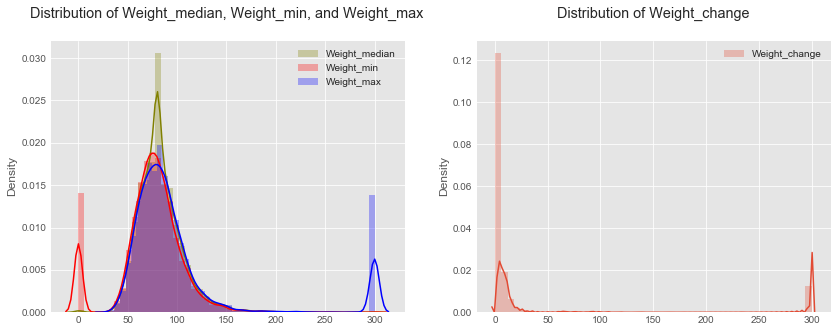

In [23]:
#impute and feature engineering (for change in min vs max)
weight = median_impute_values(weight, "weight_median")
weight = min_impute_values(weight, "weight_min")
weight = max_impute_values(weight, "weight_max")

weight["weight_range"]=weight["weight_max"]-weight["weight_min"] #Weight change from min to max

#plot
norm_hist_plotter(weight["weight_median"], weight["weight_min"], weight["weight_max"],weight["weight_range"],"Weight_median","Weight_min", "Weight_max", "Weight_change") 

There are some patients with very low weights (in the min_weight group) - this does not make sense as this is a population of adults. Also Weight_max values at 300Kgs seems suspicious.

These potentially reflect entry errors in patient weight and these could explain the very sizeable (positive) weight change in some patients.  These outliers will be "capped".

In [24]:
#Identify %ile level distribution of each column in weight dataframe for outlier capping

weight.describe(percentiles = [0.025, 0.05, 0.1, 0.25, 0.5, 0.9, 0.95, 0.975, 0.99]).T

,count,mean,std,min,2.5%,5%,10%,25%,50%,90%,95%,97.5%,99%,max
weight_median,4000.0,82.867115,23.324422,0.0,47.7950,52.0,57.8,68.200,80.0,110.00,123.115,138.0,158.010,300.0
weight_min,4000.0,74.234063,31.638113,0.0,0.0000,0.0,45.0,61.475,75.9,107.01,120.000,134.0,152.202,300.0
weight_max,4000.0,100.024355,61.172275,31.7,48.8975,53.0,58.5,69.000,83.0,138.53,300.000,300.0,300.000,300.0
weight_range,4000.0,25.790293,78.283987,0.0,0.0000,0.0,0.0,0.000,0.0,21.30,300.000,300.0,300.000,300.0


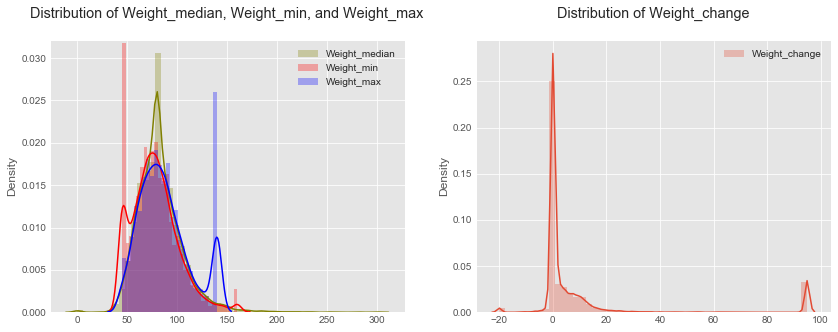

In [25]:
#Capping of weight_min, weight_max

weight['weight_min'] = np.where(weight['weight_min'] < 45, 45, weight["weight_min"]) # capped at <10%ile of distribution
weight['weight_min'] = np.where(weight['weight_min'] > 153 ,160, weight["weight_min"]) # capped at >99%ile of distribution

weight['weight_max'] = np.where(weight['weight_max'] < 48.9, 45, weight["weight_max"]) # capped at <2.5%ile of distribution
weight['weight_max'] = np.where(weight['weight_max'] > 138.53 ,140, weight["weight_max"]) # capped at >90%ile of distribution

#recalculate weight_range(weight_change)
weight["weight_range"]=weight["weight_max"]-weight["weight_min"]

#plot
norm_hist_plotter(weight["weight_median"], weight["weight_min"], weight["weight_max"],weight["weight_range"],"Weight_median","Weight_min", "Weight_max", "Weight_change")

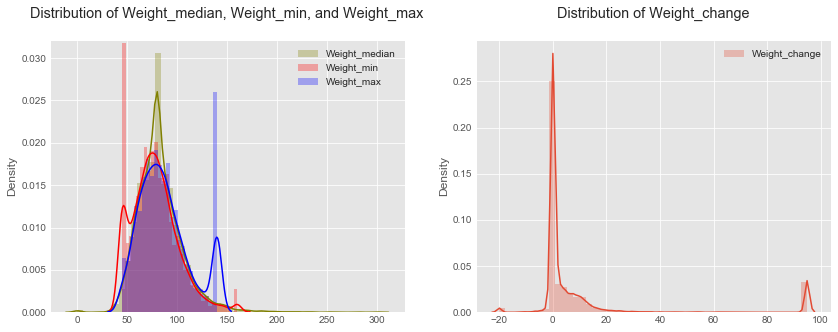

In [26]:
#plot
norm_hist_plotter(weight["weight_median"], weight["weight_min"], weight["weight_max"],weight["weight_range"],"Weight_median","Weight_min", "Weight_max", "Weight_change") 

**3.02: ALP feature extraction**

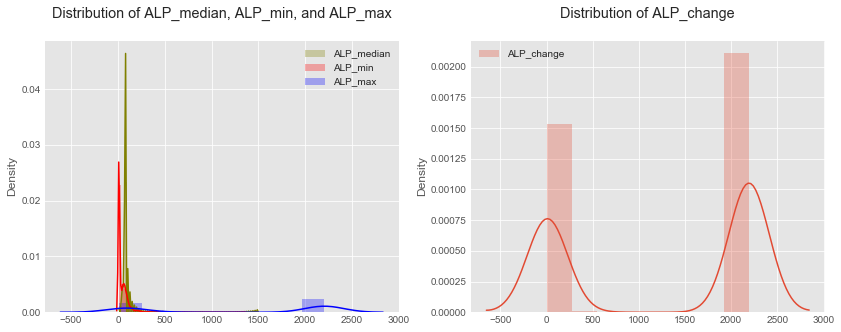

In [27]:
#Extract ALP (Alkaline Phosphatase) levels in IU/L and plot distributions of extracted values

alpm=ts.filter(regex='ALP')

#row-wise (patient-wise) values for median, min, max
alp = alpm.T.describe().T

alp = alp[["50%", "min", "max"]]
alp.columns=["alp_median", "alp_min", "alp_max"]

alp=alp.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
alp = median_impute_values(alp, "alp_median")
alp = min_impute_values(alp, "alp_min")
alp = max_impute_values(alp, "alp_max")

alp["alp_change"]=alp["alp_max"]-alp["alp_min"]

#plot
norm_hist_plotter(alp["alp_median"], alp["alp_min"], alp["alp_max"],alp["alp_change"],"ALP_median","ALP_min", "ALP_max", "ALP_change")

Liver enzyme - ALP levels change quite sizeably in a large # of patients.

**3.03: ALT feature extraction**

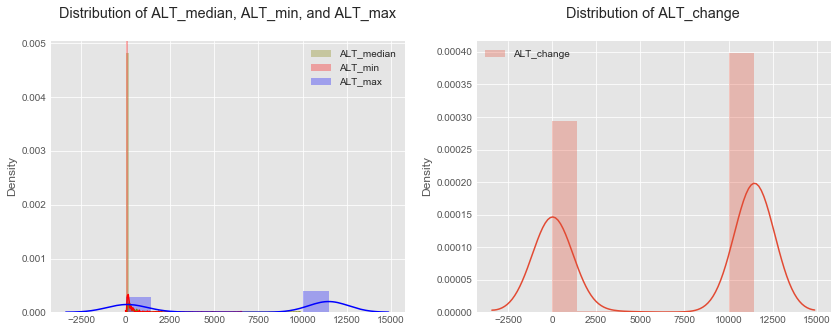

In [28]:
#Extract ALT (Alanine Transferase) levels in IU/L and plot distributions of extracted values

altm=ts.filter(regex='ALT')

#row-wise (patient-wise) values for median, min, max
alt = altm.T.describe().T

alt = alt[["50%", "min", "max"]]
alt.columns=["alt_median", "alt_min", "alt_max"]

alt=alt.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
alt = median_impute_values(alt, "alt_median")
alt = min_impute_values(alt, "alt_min")
alt = max_impute_values(alt, "alt_max")

alt["alt_change"]=alt["alt_max"]-alt["alt_min"]

#plot
norm_hist_plotter(alt["alt_median"], alt["alt_min"], alt["alt_max"],alt["alt_change"],"ALT_median","ALT_min", "ALT_max", "ALT_change") 

Similar patter of liver enzyme change (as for ALT) for AST seen in large fraction of patients

**3.04: AST feature extraction**

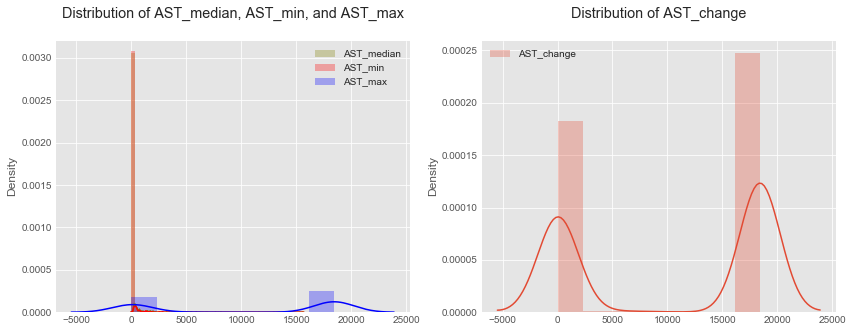

In [29]:
#Extract AST (Aspartate aminotransferase) levels and plot distributions of extracted values

astm=ts.filter(regex='AST')

#row-wise (patient-wise) values for median, min, max
ast = astm.T.describe().T

ast = ast[["50%", "min", "max"]]
ast.columns=["ast_median", "ast_min", "ast_max"]

ast=ast.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
ast = median_impute_values(ast, "ast_median")
ast = min_impute_values(ast, "ast_min")
ast = max_impute_values(ast, "ast_max")

ast["ast_change"]=ast["ast_max"]-ast["ast_min"]

#plot
norm_hist_plotter(ast["ast_median"], ast["ast_min"], ast["ast_max"],ast["ast_change"],"AST_median","AST_min", "AST_max", "AST_change") 

Large fraction of patients are increasing their liver enzyme - AST levels 

**3.05: ALB feature extraction**

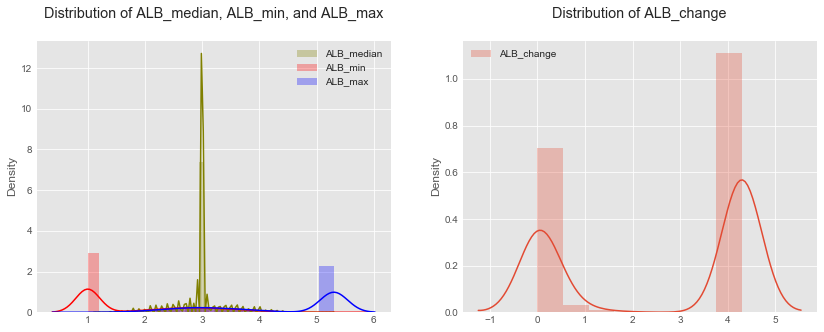

In [30]:
#Extract Albumin (alb) levels in g/dL and plot distributions of extracted values

albm=ts.filter(regex='Albumin')

#row-wise (patient-wise) values for median, min, max
alb = albm.T.describe().T

alb = alb[["50%", "min", "max"]]
alb.columns=["alb_median", "alb_min", "alb_max"]

alb=alb.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
alb = median_impute_values(alb, "alb_median")
alb = min_impute_values(alb, "alb_min")
alb = max_impute_values(alb, "alb_max")

alb["alb_change"]=alb["alb_max"]-alb["alb_min"]

#plot
norm_hist_plotter(alb["alb_median"], alb["alb_min"], alb["alb_max"],alb["alb_change"],"ALB_median","ALB_min", "ALB_max", "ALB_change") 

Liver enzyme - Albumin levels change quite sizeably in a large # of patients.

**3.06: BUN feature extraction**

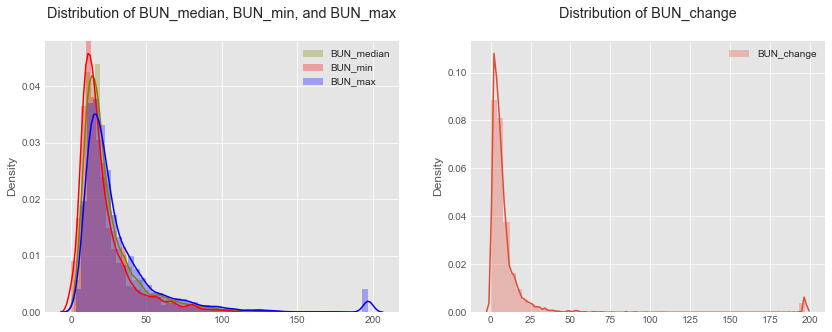

In [31]:
#Extract bun (Blood urea nitrogen) levels in mg/dL or impute for missing values. Plot extracted values.

bunm=ts.filter(regex='BUN')

#row-wise (patient-wise) values for median, min, max
bun = bunm.T.describe().T

bun = bun[["50%", "min", "max"]]
bun.columns=["bun_median", "bun_min", "bun_max"]

bun=bun.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
bun = median_impute_values(bun, "bun_median")
bun = min_impute_values(bun, "bun_min")
bun = max_impute_values(bun, "bun_max")

bun["bun_change"]=bun["bun_max"] - bun["bun_min"]

#plot
norm_hist_plotter(bun["bun_median"], bun["bun_min"], bun["bun_max"],bun["bun_change"],"BUN_median","BUN_min", "BUN_max", "BUN_change") 

**3.07: Bilirubin feature extraction**

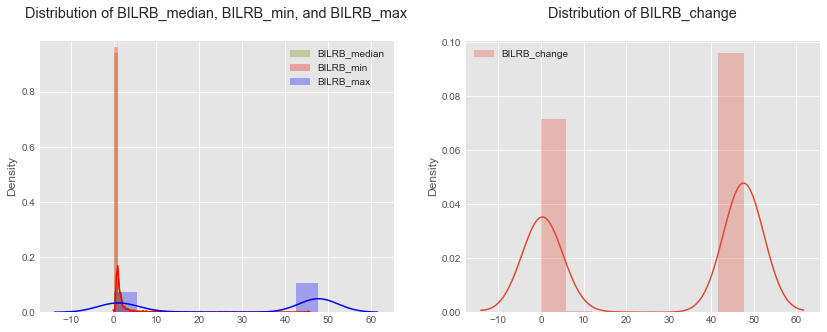

In [32]:
#Extract bilirubin (bil) levels in mg/dL or impute for missing values. Plot extracted values.

bilm=ts.filter(regex='Bilirubin')

#row-wise (patient-wise) values for median, min, max
bil = bilm.T.describe().T

bil = bil[["50%", "min", "max"]]
bil.columns=["bil_median", "bil_min", "bil_max"]

bil=bil.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
bil = median_impute_values(bil, "bil_median")
bil = min_impute_values(bil, "bil_min")
bil = max_impute_values(bil, "bil_max")

bil["bil_change"]=bil["bil_max"] - bil["bil_min"]

#plot
norm_hist_plotter(bil["bil_median"], bil["bil_min"], bil["bil_max"],bil["bil_change"],"BILRB_median","BILRB_min", "BILRB_max", "BILRB_change") 

**3.08: CHOL feature extraction**

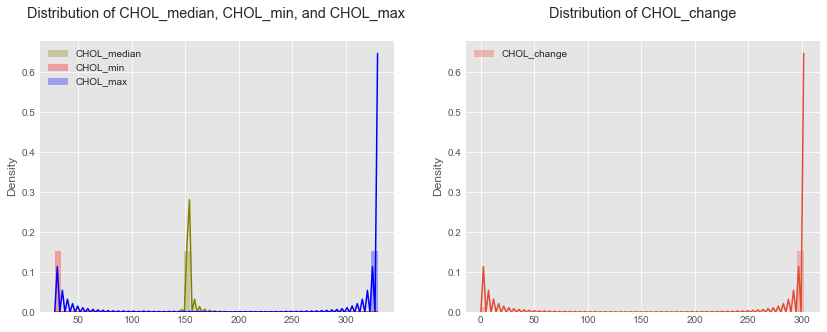

In [33]:
#Extract Cholesterol (chol) levels in mg/dL and plot distributions of extracted values

cholm=ts.filter(regex='Cholesterol')

#row-wise (patient-wise) values for median, min, max
chol = cholm.T.describe().T

chol = chol[["50%", "min", "max"]]
chol.columns=["chol_median", "chol_min", "chol_max"]

chol=chol.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
chol = median_impute_values(chol, "chol_median")
chol = min_impute_values(chol, "chol_min")
chol = max_impute_values(chol, "chol_max")

chol["chol_change"]=chol["chol_max"] - chol["chol_min"]

#plot
norm_hist_plotter(chol["chol_median"], chol["chol_min"], chol["chol_max"],chol["chol_change"],"CHOL_median","CHOL_min", "CHOL_max", "CHOL_change") 

**3.09: Creatinine feature extraction**

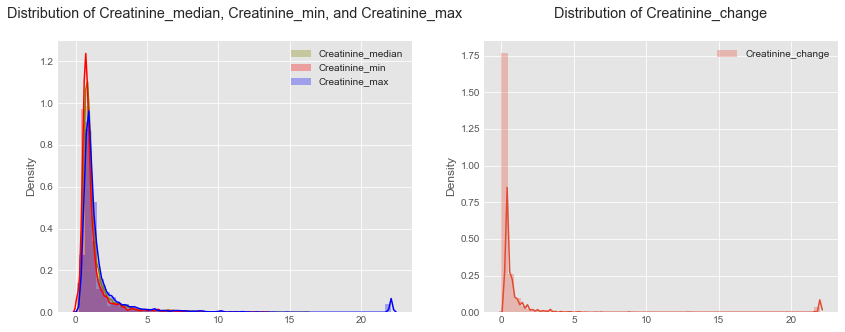

In [34]:
#Extract Creatinine (creat) levels in mg/dL and plot distributions of extracted values
creatm=ts.filter(regex='Creatinine')

#row-wise (patient-wise) values for median, min, max
creat = creatm.T.describe().T

creat = creat[["50%", "min", "max"]]
creat.columns=["creat_median", "creat_min", "creat_max"]

creat=creat.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
creat = median_impute_values(creat, "creat_median")
creat = min_impute_values(creat, "creat_min")
creat = max_impute_values(creat, "creat_max")

creat["creat_change"]=creat["creat_max"] - creat["creat_min"]

#plot
norm_hist_plotter(creat["creat_median"], creat["creat_min"], creat["creat_max"],creat["creat_change"],"Creatinine_median","Creatinine_min", "Creatinine_max", "Creatinine_change") 

**3.10: DiasABP feature extraction**

In [35]:
#Extract DIASBP levels in mmHg units and plot distributions of extracted values
diasm=ts.filter(regex='DiasABP')

#row-wise (patient-wise) values for median, min, max
dia = diasm.T.describe().T

dia = dia[["50%", "min", "max"]]
dia.columns = ["dia_median", "dia_min", "dia_max"]

dia=dia.fillna(-1)

In [36]:
#descriptive stats for outlier detection/capping needed
dia.describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,dia_median,dia_min,dia_max
count,4000.000000,4000.000000,4000.000000
mean,57.766375,34.917000,86.474750
std,12.429606,15.602499,21.656907
min,-1.000000,-1.000000,-1.000000
1%,-1.000000,-1.000000,-1.000000
2.5%,37.500000,0.000000,57.000000
5%,43.000000,0.000000,63.000000
10%,46.500000,0.000000,67.000000
15%,48.500000,21.000000,71.000000
25%,52.000000,29.000000,75.000000


**Note**: If mean arterial pressure falls below 60 (mmHg units) for an appreciable length of time, vital organs can be deprived of oxygen (https://www.reference.com/health/normal-mean-arterial-pressure-range-bf5aa6f391c462a1).
 
Presence of values less than 60 is seen in above distribution - and may indicate high risk patients.

Presence of dia_max ~268 seems suspicious. I will cap this to 99th%ile of its distribution. Similarly, values of dia_min = 0.00 seem suspicious and I will cap at 15th%ile value.

In [37]:
#Capping of dia_max and dia_min
dia['dia_max'] = np.where(dia['dia_max'] > 151, 160, dia["dia_max"]) # capped at >99%ile of distribution
dia['dia_min'] = np.where(dia['dia_min'] < 21, 20, dia["dia_min"])# capped at <15%ile of distribution

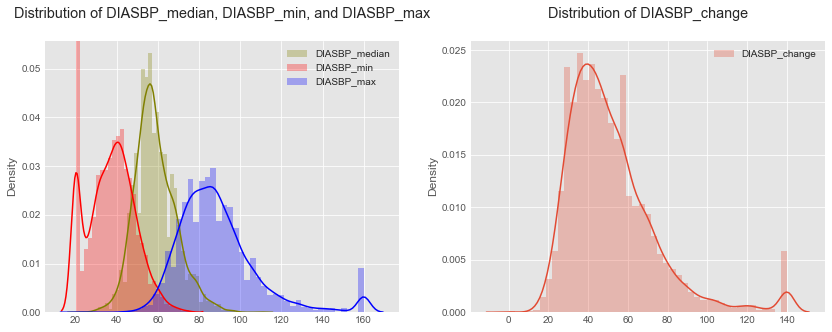

In [38]:
#impute and feature engineering (for change from min to max)
dia = median_impute_values(dia, "dia_median")
dia = min_impute_values(dia, "dia_min")
dia = max_impute_values(dia, "dia_max")

dia["dia_change"] = dia["dia_max"] - dia["dia_min"]

#plot
norm_hist_plotter(dia["dia_median"], dia["dia_min"], dia["dia_max"],dia["dia_change"],"DIASBP_median","DIASBP_min", "DIASBP_max", "DIASBP_change") 

Note small % of patients with large DIASBP max values and DIASBP change.

**3.11: Fio2 feature extraction**

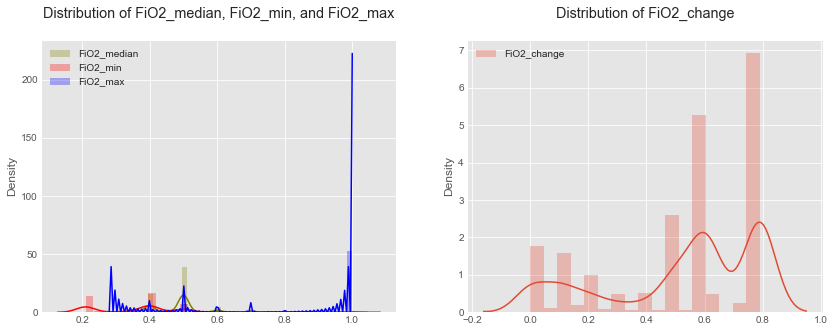

In [39]:
#Extract FiO2 (Fractional inspired O2) levels on a 0-1 scale and plot distributions of extracted values
fiom=ts.filter(regex='FiO2')

#row-wise (patient-wise) values for median, min, max
fio = fiom.T.describe().T

fio = fio[["50%", "min", "max"]]
fio.columns = ["fio_median", "fio_min", "fio_max"]

fio = fio.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
fio = median_impute_values(fio, "fio_median")
fio = min_impute_values(fio, "fio_min")
fio = max_impute_values(fio, "fio_max")

fio["fio_change"] = fio["fio_max"] - fio["fio_min"]

#plot
norm_hist_plotter(fio["fio_median"], fio["fio_min"], fio["fio_max"],fio["fio_change"],"FiO2_median","FiO2_min", "FiO2_max", "FiO2_change") 

**3.12: GCS (Glasgow Coma Score) feature extraction**

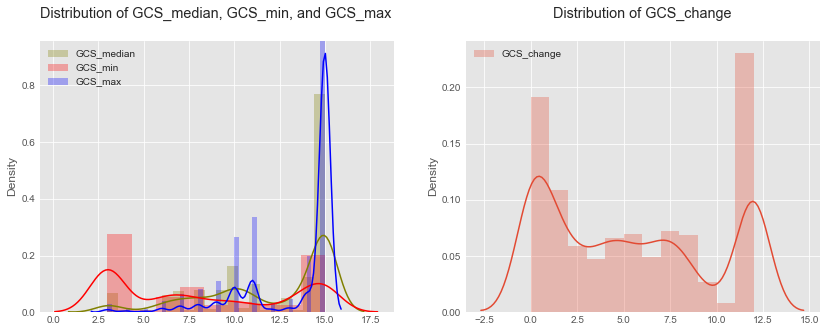

In [40]:
#Extract GCS (Glasgow Coma Score) levels and plot distributions of extracted values
gcsm=ts.filter(regex='GCS')

#row-wise (patient-wise) values for median, min, max
gcs = gcsm.T.describe().T

gcs = gcs[["50%", "min", "max"]]
gcs.columns = ["gcs_median", "gcs_min", "gcs_max"]

gcs = gcs.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
gcs = median_impute_values(gcs, "gcs_median")
gcs = min_impute_values(gcs, "gcs_min")
gcs = max_impute_values(gcs, "gcs_max")

gcs["gcs_change"] = gcs["gcs_max"] - gcs["gcs_min"]

#plot
norm_hist_plotter(gcs["gcs_median"], gcs["gcs_min"], gcs["gcs_max"],gcs["gcs_change"],"GCS_median","GCS_min", "GCS_max", "GCS_change") 

**3.13: Glucose feature extraction**

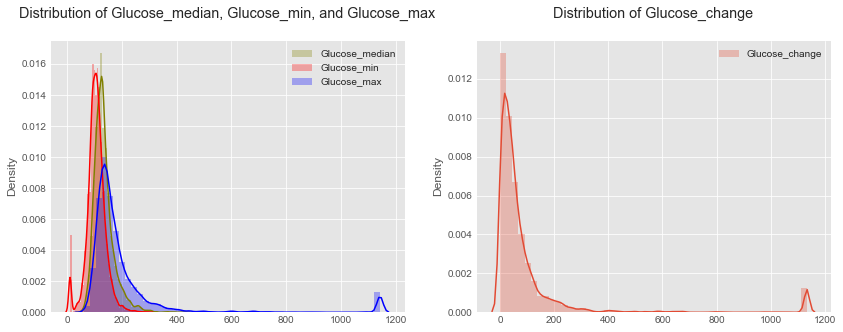

In [41]:
#Extract Glucose levels and plot distributions of extracted values
glucm=ts.filter(regex='Glucose')

#row-wise (patient-wise) values for median, min, max
gluc = glucm.T.describe().T

gluc = gluc[["50%", "min", "max"]]
gluc.columns = ["gluc_median", "gluc_min", "gluc_max"]

gluc = gluc.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
gluc = median_impute_values(gluc, "gluc_median")
gluc = min_impute_values(gluc, "gluc_min")
gluc = max_impute_values(gluc, "gluc_max")

gluc["gluc_change"] = gluc["gluc_max"] - gluc["gluc_min"]

#plot
norm_hist_plotter(gluc["gluc_median"], gluc["gluc_min"], gluc["gluc_max"],gluc["gluc_change"],"Glucose_median","Glucose_min", "Glucose_max", "Glucose_change") 

Note small number of patients with very low glucose median levels or very high glucose max levels/change. Unclear if this is an entry error but I will perform outlier capping as done previously for other features (eg: weight, DiasABP)

In [42]:
gluc.describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.975, 0.99]).T

,count,mean,std,min,1%,2.5%,5%,10%,25%,50%,75%,90%,95%,97.5%,99%,max
gluc_median,4000.0,133.428188,37.849522,49.0,72.495,80.000,88.0,95.0,110.0,127.0,148.0,179.0,205.00,229.525,264.00,489.0
gluc_min,4000.0,105.824875,33.718623,10.0,10.000,10.000,55.0,71.0,89.0,105.0,123.0,144.0,160.00,177.000,202.01,298.0
gluc_max,4000.0,200.886500,182.322113,60.0,83.000,90.975,99.0,109.0,127.0,152.0,198.0,279.0,394.10,1143.000,1143.00,1143.0
gluc_change,4000.0,95.061625,196.856588,0.0,0.000,0.000,0.0,6.0,18.0,42.0,84.0,175.0,296.05,1133.000,1133.00,1133.0


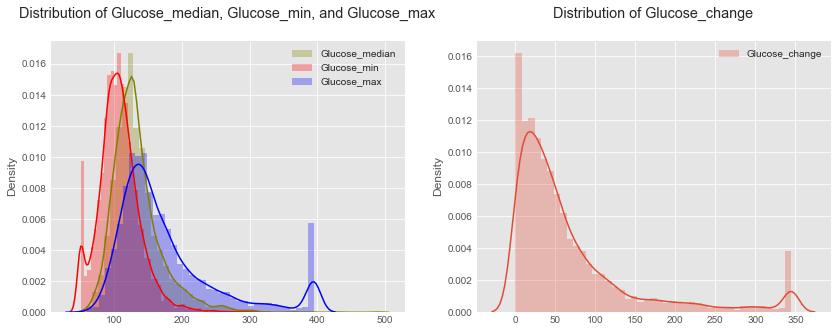

In [43]:
#outlier capping of gluc_max, gluc_min
gluc['gluc_max'] = np.where(gluc['gluc_max'] > 395, 395, gluc["gluc_max"]) # capped at >95%ile of distribution
gluc['gluc_min'] = np.where(gluc['gluc_min'] < 55, 50, gluc["gluc_min"])# capped at <5%ile of distribution

#re-calculate gluc_change
gluc["gluc_change"] = gluc["gluc_max"] - gluc["gluc_min"]

#plot
norm_hist_plotter(gluc["gluc_median"], gluc["gluc_min"], gluc["gluc_max"],gluc["gluc_change"],"Glucose_median","Glucose_min", "Glucose_max", "Glucose_change") 


**3.14: HCO3 feature extraction**

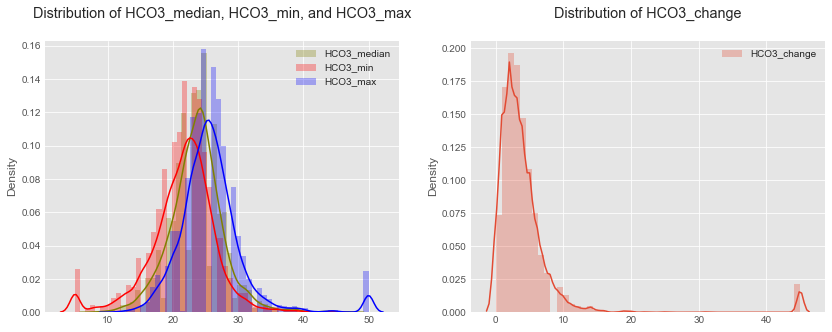

In [44]:
#Extract HCO3 levels and plot distributions of extracted values
hcom=ts.filter(regex='HCO3')

#row-wise (patient-wise) values for median, min, max
hco = hcom.T.describe().T

hco = hco[["50%", "min", "max"]]
hco.columns = ["hco_median", "hco_min", "hco_max"]

hco = hco.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
hco = median_impute_values(hco, "hco_median")
hco = min_impute_values(hco, "hco_min")
hco = max_impute_values(hco, "hco_max")

hco["hco_change"] = hco["hco_max"] - hco["hco_min"]

#plot
norm_hist_plotter(hco["hco_median"], hco["hco_min"], hco["hco_max"],hco["hco_change"],"HCO3_median","HCO3_min", "HCO3_max", "HCO3_change") 

**3.15: HCT feature extraction**

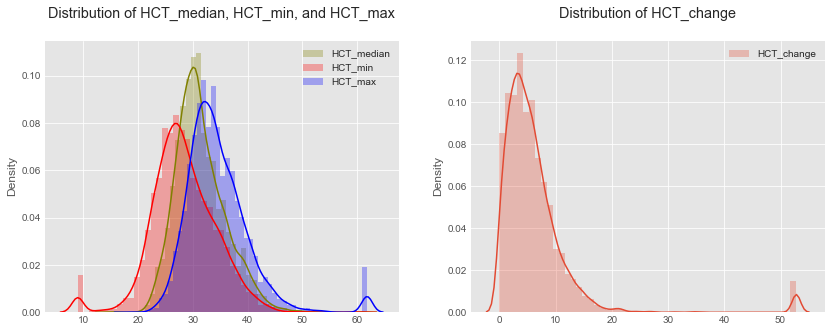

In [45]:
#Extract HCT (hematocrit) levels and plot distributions of extracted values
hctm=ts.filter(regex='HCT')

#row-wise (patient-wise) values for median, min, max
hct = hctm.T.describe().T

hct = hct[["50%", "min", "max"]]
hct.columns = ["hct_median", "hct_min", "hct_max"]

hct = hct.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
hct = median_impute_values(hct, "hct_median")
hct = min_impute_values(hct, "hct_min")
hct = max_impute_values(hct, "hct_max")

hct["hct_change"] = hct["hct_max"] - hct["hct_min"]

#plot
norm_hist_plotter(hct["hct_median"], hct["hct_min"], hct["hct_max"],hct["hct_change"],"HCT_median","HCT_min", "HCT_max", "HCT_change") 

**3.16: HR (Heart Rate) feature extraction**

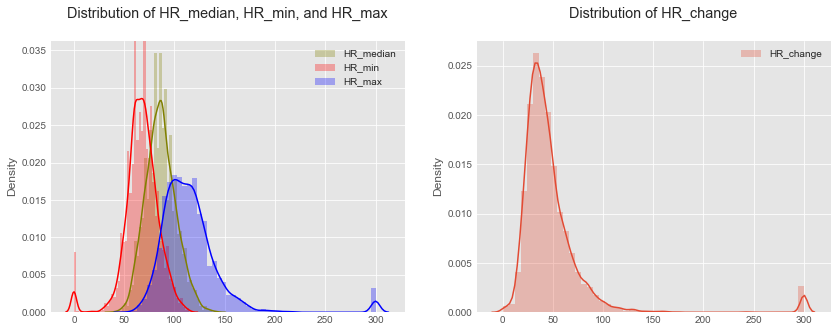

In [46]:
#Extract HR (heart rate in bpm) levels and plot distributions of extracted values
hrm=ts.filter(regex='HR')

#row-wise (patient-wise) values for median, min, max
hr = hrm.T.describe().T

hr = hr[["50%", "min", "max"]]
hr.columns = ["hr_median", "hr_min", "hr_max"]

hr = hr.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
hr = median_impute_values(hr, "hr_median")
hr = min_impute_values(hr, "hr_min")
hr = max_impute_values(hr, "hr_max")

hr["hr_change"] = hr["hr_max"] - hr["hr_min"]

#plot
norm_hist_plotter(hr["hr_median"], hr["hr_min"], hr["hr_max"],hr["hr_change"],"HR_median","HR_min", "HR_max", "HR_change") 

Note "suspicious" outliers for heart rate (~0 and ~300 in above distributions). I will "cap" these as done previously for other features.

In [47]:
hr.describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.975, 0.99]).T

,count,mean,std,min,1%,2.5%,5%,10%,25%,50%,75%,90%,95%,97.5%,99%,max
hr_median,4000.0,86.377375,14.889617,40.0,55.495,60.0,63.0,68.0,76.0,86.0,96.0,106.0,112.0,118.0,123.5,142.0
hr_min,4000.0,67.409775,16.716088,0.0,0.000,34.0,44.0,50.0,59.0,68.0,77.0,87.0,93.0,98.0,104.0,115.0
hr_max,4000.0,115.404550,32.206817,53.0,70.000,76.0,81.0,87.0,97.0,111.0,126.0,144.0,159.0,175.0,300.0,300.0
hr_change,4000.0,47.994775,38.011673,0.0,13.000,16.0,19.0,23.0,30.0,40.0,54.0,74.0,90.0,116.0,300.0,300.0


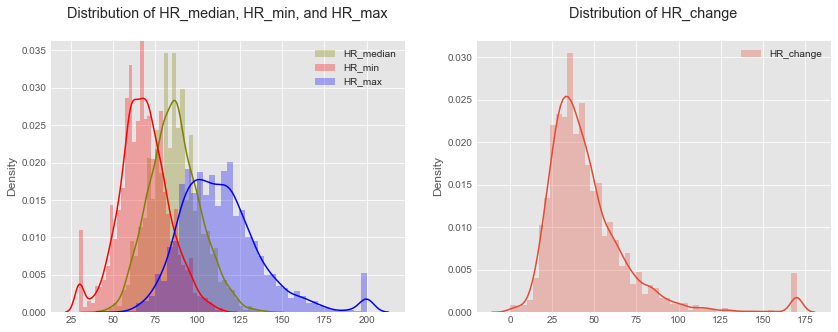

In [48]:
#outlier capping of hr_min, hr_min, recalculate hr_change, and plot
hr['hr_min'] = np.where(hr['hr_min'] < 34, 30, hr["hr_min"])# capped at <2.5%ile of distribution
hr['hr_max'] = np.where(hr['hr_max'] > 200, 200, hr["hr_max"]) # capped at >97.5%ile of distribution

hr["hr_change"] = hr["hr_max"] - hr["hr_min"]#re-calculate hr_change

#plot
norm_hist_plotter(hr["hr_median"], hr["hr_min"], hr["hr_max"],hr["hr_change"],"HR_median","HR_min", "HR_max", "HR_change") 

**3.17: K (Potassium) feature extraction**

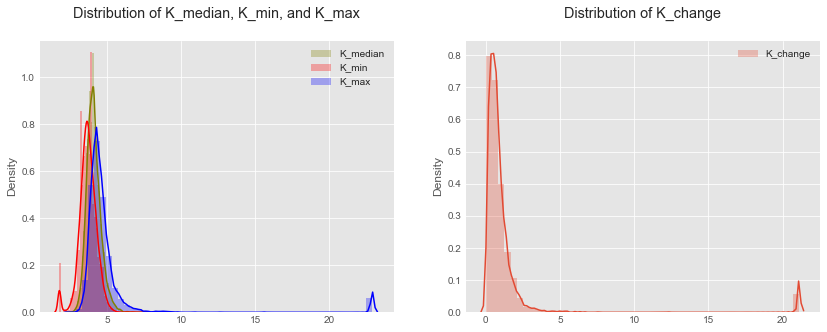

In [49]:
#Extract K (potassium) levels and plot distributions of extracted values
potm=ts.filter(regex='K')

#row-wise (patient-wise) values for median, min, max
pot = potm.T.describe().T

pot = pot[["50%", "min", "max"]]
pot.columns = ["pot_median", "pot_min", "pot_max"]

pot = pot.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
pot = median_impute_values(pot, "pot_median")
pot = min_impute_values(pot, "pot_min")
pot = max_impute_values(pot, "pot_max")

pot["pot_change"] = pot["pot_max"] - pot["pot_min"]

#plot
norm_hist_plotter(pot["pot_median"], pot["pot_min"], pot["pot_max"],pot["pot_change"],"K_median","K_min", "K_max", "K_change") 

**3.18: Lactate feature extraction**

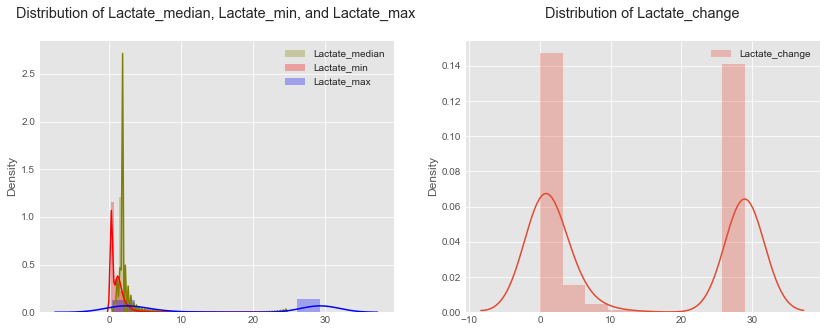

In [50]:
#Extract Lactate levels and plot distributions of extracted values
lacm=ts.filter(regex='Lactate')

#row-wise (patient-wise) values for median, min, max
lac = lacm.T.describe().T

lac = lac[["50%", "min", "max"]]
lac.columns = ["lac_median", "lac_min", "lac_max"]

lac = lac.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
lac = median_impute_values(lac, "lac_median")
lac = min_impute_values(lac, "lac_min")
lac = max_impute_values(lac, "lac_max")

lac["lac_change"] = lac["lac_max"] - lac["lac_min"]

#plot
norm_hist_plotter(lac["lac_median"], lac["lac_min"], lac["lac_max"],lac["lac_change"],"Lactate_median","Lactate_min", "Lactate_max", "Lactate_change") 

**3.19: MAP feature extraction**

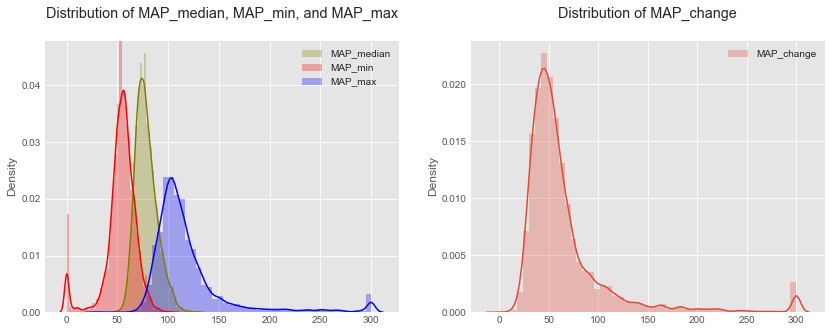

In [51]:
#Extract MAP (invasive mean arterial blood pressure in mmHg units) levels and plot distributions of extracted values
mapm=ts.filter(regex='MAP')

#row-wise (patient-wise) values for median, min, max
mapi = mapm.T.describe().T

mapi = mapi[["50%", "min", "max"]]
mapi.columns = ["MAP_median", "MAP_min", "MAP_max"]

mapi = mapi.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
mapi = median_impute_values(mapi, "MAP_median")
mapi = min_impute_values(mapi, "MAP_min")
mapi = max_impute_values(mapi, "MAP_max")

mapi["MAP_change"] = mapi["MAP_max"] - mapi["MAP_min"]

#plot
norm_hist_plotter(mapi["MAP_median"], mapi["MAP_min"], mapi["MAP_max"],mapi["MAP_change"],"MAP_median","MAP_min", "MAP_max", "MAP_change") 

Note suspicious values around invasive MAP values of 0 and 300 above. As done previously, I will cap these outliers.

In [52]:
mapi.describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.2, 0.5, 0.9, 0.95, 0.975, 0.99]).T

,count,mean,std,min,1%,2.5%,5%,10%,20%,50%,90%,95%,97.5%,99%,max
MAP_median,4000.0,78.321972,10.602309,30.0,59.0,61.5,63.67,66.3135,69.500,77.0,93.0,98.0000,103.00000,107.0,129.5
MAP_min,4000.0,53.598300,15.503337,0.0,0.0,0.0,23.00,39.3300,46.000,55.0,69.0,74.0000,79.00000,83.0,104.0
MAP_max,4000.0,118.735168,39.447582,30.0,77.0,81.0,85.00,89.0000,95.934,108.0,152.0,201.0000,264.00000,300.0,300.0
MAP_change,4000.0,65.136867,45.839529,0.0,23.0,26.0,29.00,33.0000,38.000,52.0,108.0,150.0165,214.34675,300.0,300.0


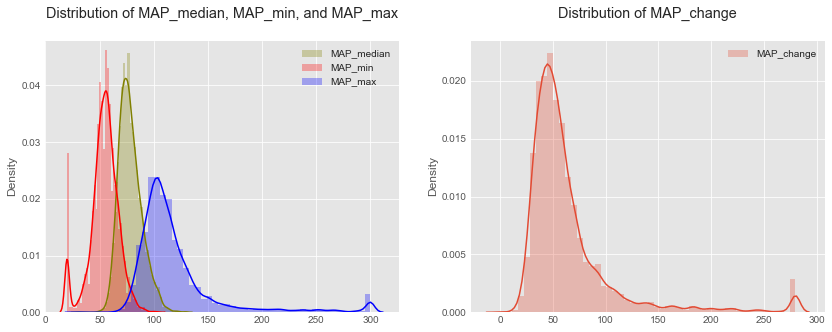

In [53]:
#outlier capping of MAP_min, recalculate MAP_change, and plot
mapi['MAP_min'] = np.where(mapi['MAP_min'] < 23, 20, mapi["MAP_min"])# capped at <5%ile of distribution

mapi["MAP_change"] = mapi["MAP_max"] - mapi["MAP_min"] # reclalculate MAP_change

#plot
norm_hist_plotter(mapi["MAP_median"], mapi["MAP_min"], mapi["MAP_max"],mapi["MAP_change"],"MAP_median","MAP_min", "MAP_max", "MAP_change") 

**3.20: MechVent feature extraction**

In [54]:
#Extract MechVent (Mechanical ventilation respiration - True/False) levels and plot distributions of extracted values
MVm=ts.filter(regex='MechVent')

#row-wise (patient-wise) values for sum (# of time-points measured during which patient was on mechanical vent)
MV = MVm.T.describe().T

MV["MV_count"]=MV[MV.columns].sum(axis=1)

MV.info()# non null values in MV_count! No need to impute (and we will use MV_count as the feature of interest from this dataframe)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 132539 to 142673
Data columns (total 9 columns):
count       4000 non-null float64
mean        2529 non-null float64
std         2507 non-null float64
min         2529 non-null float64
25%         2529 non-null float64
50%         2529 non-null float64
75%         2529 non-null float64
max         2529 non-null float64
MV_count    4000 non-null float64
dtypes: float64(9)
memory usage: 312.5 KB


**3.21: Mg (Magnesium) feature extraction**

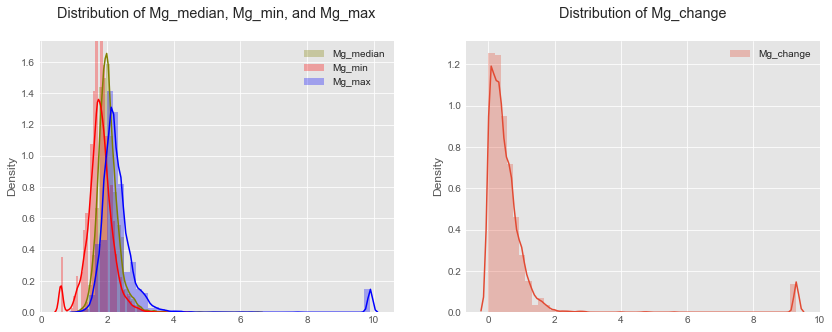

In [55]:
#Extract Mg (Magnesium) levels and plot distributions of extracted values
mgm=ts.filter(regex='Mg')

#row-wise (patient-wise) values for median, min, max
mg = mgm.T.describe().T

mg = mg[["50%", "min", "max"]]
mg.columns = ["mg_median", "mg_min", "mg_max"]

mg = mg.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
mg = median_impute_values(mg, "mg_median")
mg = min_impute_values(mg, "mg_min")
mg = max_impute_values(mg, "mg_max")

mg["mg_change"] = mg["mg_max"] - mg["mg_min"]

#plot
norm_hist_plotter(mg["mg_median"], mg["mg_min"], mg["mg_max"],mg["mg_change"],"Mg_median","Mg_min", "Mg_max", "Mg_change") 

**3.22: NIDiasABP feature extraction**

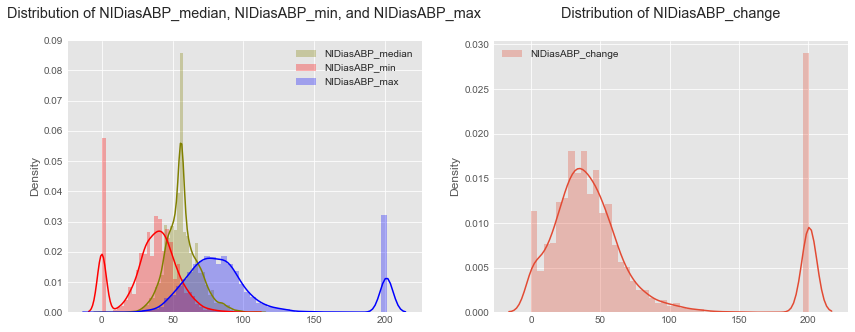

In [56]:
#Extract NIDiasABP (Non-invasive diastolic arterial blood pressure in mmHg units) levels and plot distributions of extracted values
nidiam=ts.filter(regex='NIDiasABP')

#row-wise (patient-wise) values for median, min, max
nidia = nidiam.T.describe().T

nidia = nidia[["50%", "min", "max"]]
nidia.columns = ["nidia_median", "nidia_min", "nidia_max"]

nidia = nidia.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
nidia = median_impute_values(nidia, "nidia_median")
nidia = min_impute_values(nidia, "nidia_min")
nidia = max_impute_values(nidia, "nidia_max")

nidia["nidia_change"] = nidia["nidia_max"] - nidia["nidia_min"]

#plot
norm_hist_plotter(nidia["nidia_median"], nidia["nidia_min"], nidia["nidia_max"],nidia["nidia_change"],"NIDiasABP_median","NIDiasABP_min", "NIDiasABP_max", "NIDiasABP_change") 

Note patients with very low min-NIDIABP values and also patients with large values for NiDiasABP_Max, NiDiasABP_change. As done before, I will evaluate further to cap outliers.

In [57]:
nidia.describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.2, 0.5, 0.9, 0.95, 0.975, 0.99]).T

,count,mean,std,min,1%,2.5%,5%,10%,20%,50%,90%,95%,97.5%,99%,max
nidia_median,4000.0,56.644375,11.349358,0.0,31.995,36.0,39.0,43.5,48.0,56.0,71.05,77.0,83.0125,89.0,110.0
nidia_min,4000.0,34.679500,18.807531,0.0,0.000,0.0,0.0,0.0,22.0,37.0,56.00,62.0,67.0000,75.0,103.0
nidia_max,4000.0,95.014250,44.652626,0.0,40.000,46.0,51.0,57.0,65.0,82.0,201.00,201.0,201.0000,201.0,201.0
nidia_change,4000.0,60.334750,58.330586,0.0,0.000,0.0,4.0,13.0,23.0,42.0,201.00,201.0,201.0000,201.0,201.0


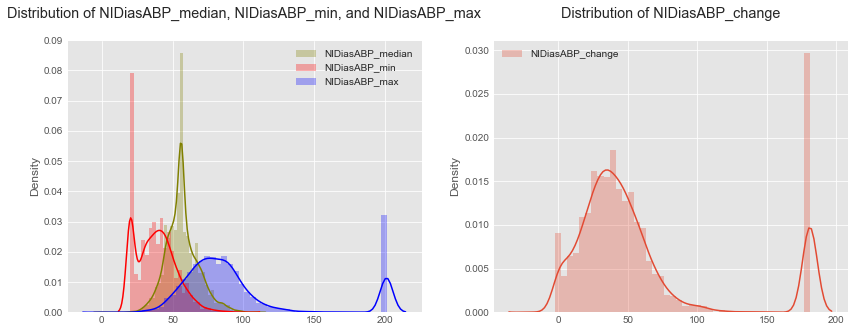

In [58]:
#outlier capping, recalculate nidia_change, and plot
nidia['nidia_min'] = np.where(nidia['nidia_min'] < 22, 20, nidia["nidia_min"])# capped at < 20%ile of distribution

nidia["nidia_change"] = nidia["nidia_max"] - nidia["nidia_min"] # reclalculate nidia_change

#plot
norm_hist_plotter(nidia["nidia_median"], nidia["nidia_min"], nidia["nidia_max"],nidia["nidia_change"],"NIDiasABP_median","NIDiasABP_min", "NIDiasABP_max", "NIDiasABP_change") 

**3.23: NIMAP feature extraction**

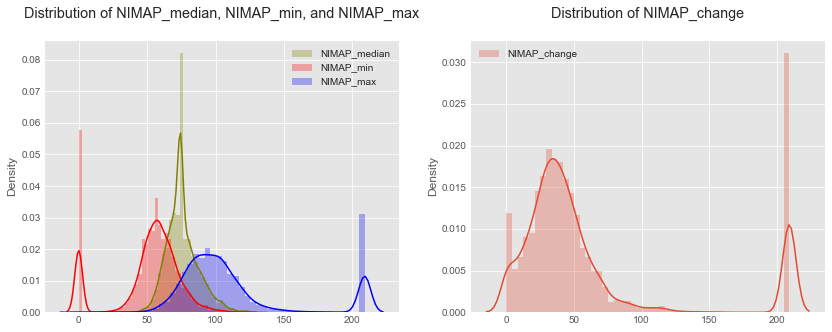

In [59]:
#Extract NIMAP (Non-invasive mean arterial blood pressure in mmHg units) levels and plot distributions of extracted values
nimapm=ts.filter(regex='NIMAP')

#row-wise (patient-wise) values for median, min, max
nimap = nimapm.T.describe().T

nimap = nimap[["50%", "min", "max"]]
nimap.columns = ["nimap_median", "nimap_min", "nimap_max"]

nimap = nimap.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
nimap = median_impute_values(nimap, "nimap_median")
nimap = min_impute_values(nimap, "nimap_min")
nimap = max_impute_values(nimap, "nimap_max")

nimap["nimap_change"] = nimap["nimap_max"] - nimap["nimap_min"]

#plot
norm_hist_plotter(nimap["nimap_median"], nimap["nimap_min"], nimap["nimap_max"],nimap["nimap_change"],"NIMAP_median","NIMAP_min", "NIMAP_max", "NIMAP_change") 

Note patients with very low min-NIMAP values and also patients with large level changes (Similar to NIDIA levels). As done before,  will evaluate further for outlier capping.

In [60]:
nimap.describe(percentiles=[0.01, 0.025, 0.05, 0.1,0.15, 0.2, 0.5, 0.9, 0.95, 0.975, 0.99]).T

,count,mean,std,min,1%,2.5%,5%,10%,15%,20%,50%,90%,95%,97.5%,99%,max
nimap_median,4000.0,75.662922,11.699053,0.0,51.9967,56.0,59.0000,62.165,64.67,66.798,74.33,91.332,97.5085,103.505,109.5000,132.0
nimap_min,4000.0,51.382320,23.993137,0.0,0.0000,0.0,0.0000,0.000,33.00,42.670,56.33,74.670,81.0000,87.670,96.6766,121.0
nimap_max,4000.0,111.300623,41.679344,0.0,59.3300,64.0,70.0000,76.000,79.67,83.000,99.00,209.000,209.0000,209.000,209.0000,209.0
nimap_change,4000.0,59.918302,61.075488,0.0,0.0000,0.0,4.3135,12.669,18.00,22.670,39.63,209.000,209.0000,209.000,209.0000,209.0


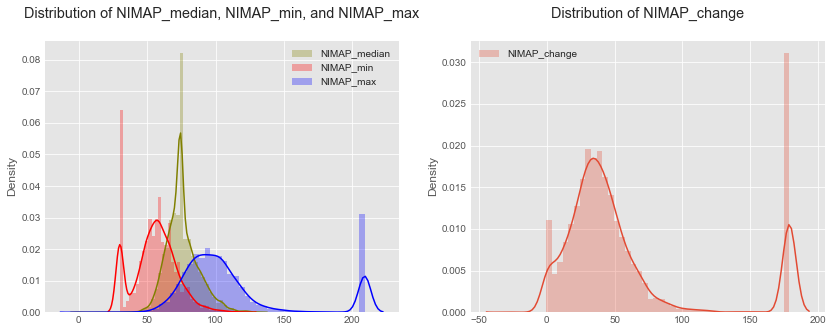

In [61]:
#outlier capping, recalculate nidia_change, and plot
nimap['nimap_min'] = np.where(nimap['nimap_min'] < 33, 30, nimap["nimap_min"])# capped at < 15%ile of distribution

nimap["nimap_change"] = nimap["nimap_max"] - nimap["nimap_min"] # reclalculate nimap_change

#plot
norm_hist_plotter(nimap["nimap_median"], nimap["nimap_min"], nimap["nimap_max"],nimap["nimap_change"],"NIMAP_median","NIMAP_min", "NIMAP_max", "NIMAP_change") 

**3.24: NISysABP feature extraction**

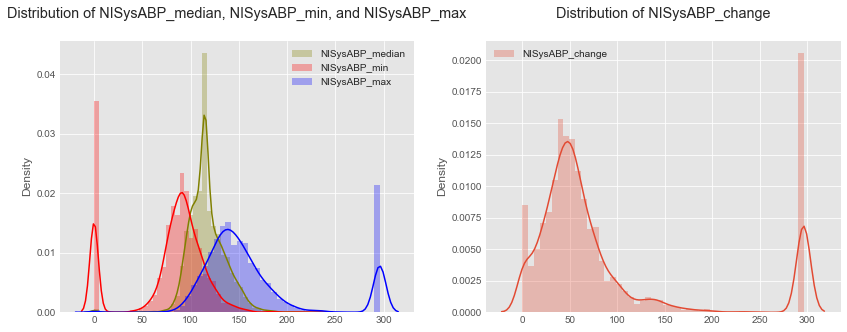

In [62]:
#Extract NISysABP (Non-invasive systolic arterial blood pressure in mmHg units) levels and plot distributions of extracted values
nisam=ts.filter(regex='NISysABP')

#row-wise (patient-wise) values for median, min, max
nisa = nisam.T.describe().T

nisa = nisa[["50%", "min", "max"]]
nisa.columns = ["nisa_median", "nisa_min", "nisa_max"]

nisa = nisa.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
nisa = median_impute_values(nisa, "nisa_median")
nisa = min_impute_values(nisa, "nisa_min")
nisa = max_impute_values(nisa, "nisa_max")

nisa["nisa_change"] = nisa["nisa_max"] - nisa["nisa_min"]

#plot
norm_hist_plotter(nisa["nisa_median"], nisa["nisa_min"], nisa["nisa_max"],nisa["nisa_change"],"NISysABP_median","NISysABP_min", "NISysABP_max", "NISysABP_change") 

Note patients with very low min-NISysABP values and also patients with large max levels/changes (Similar to NIDIA levels). As done before,  will evaluate further for outlier capping.

In [63]:
nisa.describe(percentiles=[0.01, 0.025, 0.05, 0.1,0.15, 0.2, 0.5, 0.6, 0.7,0.8, 0.85, 0.875, 0.9, 0.95]).T

,count,mean,std,min,1%,2.5%,5%,10%,15%,20%,50%,60%,70%,80%,85%,87.5%,90%,95%,max
nisa_median,4000.0,116.89950,18.793096,0.0,81.00,88.0,92.0,97.0,100.0,102.0,115.0,117.0,123.0,131.0,136.00,138.5,142.0,150.0,234.0
nisa_min,4000.0,78.93475,39.411950,0.0,0.00,0.0,0.0,0.0,0.0,65.0,89.0,93.0,99.0,106.0,111.00,113.0,116.0,126.0,234.0
nisa_max,4000.0,163.14450,56.673151,0.0,92.99,99.0,106.0,113.0,120.0,125.0,147.0,155.0,165.0,182.0,200.15,296.0,296.0,296.0,296.0
nisa_change,4000.0,84.20975,86.727231,0.0,0.00,0.0,6.0,18.0,25.0,31.0,53.0,62.0,74.0,100.0,142.00,296.0,296.0,296.0,296.0


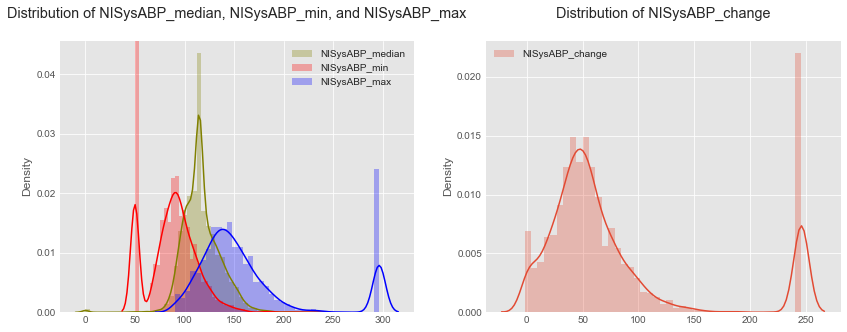

In [64]:
#outlier capping, recalculate nidia_change, and plot
nisa['nisa_min'] = np.where(nisa['nisa_min'] < 65, 50, nisa["nisa_min"])# capped at < 20%ile of distribution
nisa['nisa_max'] = np.where(nisa['nisa_max'] < 92.99, 90, nisa["nisa_max"])# capped at < 1%ile of distribution

nisa["nisa_change"] = nisa["nisa_max"] - nisa["nisa_min"] # reclalculate nisa_change

#plot
norm_hist_plotter(nisa["nisa_median"], nisa["nisa_min"], nisa["nisa_max"],nisa["nisa_change"],"NISysABP_median","NISysABP_min", "NISysABP_max", "NISysABP_change") 

**3.25: Na (Sodium) feature extraction**

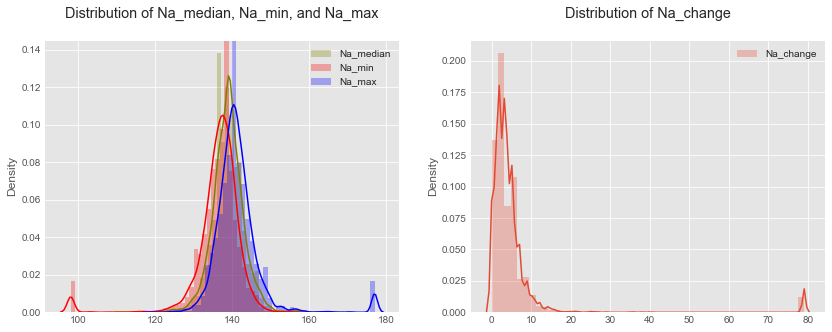

In [65]:
#Extract Na (Sodium) levels and plot distributions of extracted values
sodm=ts.filter(regex='Na')

#row-wise (patient-wise) values for median, min, max
sod = sodm.T.describe().T

sod = sod[["50%", "min", "max"]]
sod.columns = ["sod_median", "sod_min", "sod_max"]

sod = sod.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
sod = median_impute_values(sod, "sod_median")
sod = min_impute_values(sod, "sod_min")
sod = max_impute_values(sod, "sod_max")

sod["sod_change"] = sod["sod_max"] - sod["sod_min"]

#plot
norm_hist_plotter(sod["sod_median"], sod["sod_min"], sod["sod_max"],sod["sod_change"],"Na_median","Na_min", "Na_max", "Na_change") 

Note outliers on both ends for Sodium levels (min or max).

**3.26: PaCO2 feature extraction**

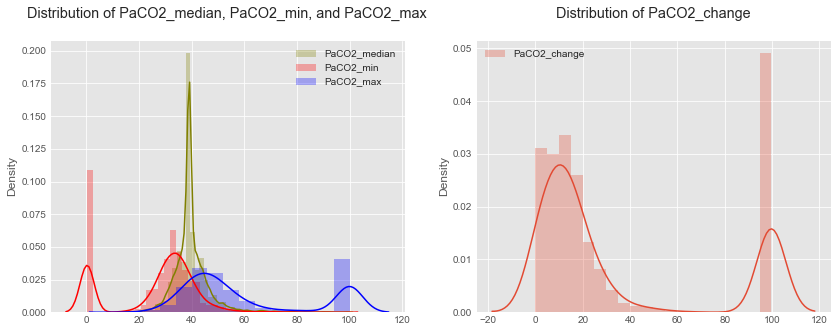

In [66]:
#Extract PaCO2 (partial pressure of arterial CO2 in mm Hg units) levels and plot distributions of extracted values
pacom=ts.filter(regex='PaCO2')

#row-wise (patient-wise) values for median, min, max
paco = pacom.T.describe().T

paco = paco[["50%", "min", "max"]]
paco.columns = ["paco_median", "paco_min", "paco_max"]

paco = paco.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
paco = median_impute_values(paco, "paco_median")
paco = min_impute_values(paco, "paco_min")
paco = max_impute_values(paco, "paco_max")

paco["paco_change"] = paco["paco_max"] - paco["paco_min"]

#plot
norm_hist_plotter(paco["paco_median"], paco["paco_min"], paco["paco_max"],paco["paco_change"],"PaCO2_median","PaCO2_min", "PaCO2_max", "PaCO2_change") 

**3.27: PaO2 feature extraction**

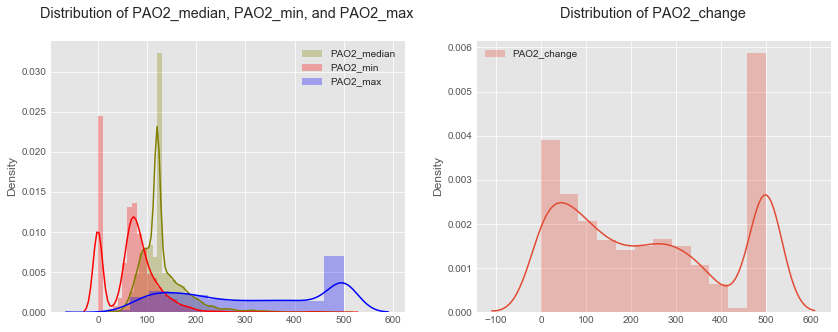

In [67]:
#Extract PaO2 (partial pressure of arterial O2 in mm Hg units) levels and plot distributions of extracted values
paom=ts.filter(regex='PaO2')

#row-wise (patient-wise) values for median, min, max
pao = paom.T.describe().T

pao = pao[["50%", "min", "max"]]
pao.columns = ["pao_median", "pao_min", "pao_max"]

pao = pao.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
pao = median_impute_values(pao, "pao_median")
pao = min_impute_values(pao, "pao_min")
pao = max_impute_values(pao, "pao_max")

pao["pao_change"] = pao["pao_max"] - pao["pao_min"]

#plot
norm_hist_plotter(pao["pao_median"], pao["pao_min"], pao["pao_max"],pao["pao_change"],"PAO2_median","PAO2_min", "PAO2_max", "PAO2_change") 

**3.28: Platelets feature extraction**

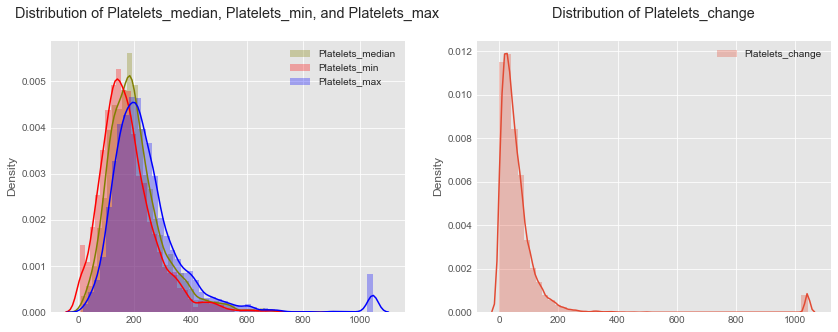

In [68]:
#Extract Platelet levels and plot distributions of extracted values
platm=ts.filter(regex='Platelets')

#row-wise (patient-wise) values for median, min, max
plat = platm.T.describe().T

plat = plat[["50%", "min", "max"]]
plat.columns = ["plat_median", "plat_min", "plat_max"]

plat = plat.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
plat = median_impute_values(plat, "plat_median")
plat = min_impute_values(plat, "plat_min")
plat = max_impute_values(plat, "plat_max")

plat["plat_change"] = plat["plat_max"] - plat["plat_min"]

#plot
norm_hist_plotter(plat["plat_median"], plat["plat_min"], plat["plat_max"],plat["plat_change"],"Platelets_median","Platelets_min", "Platelets_max", "Platelets_change") 

**3.29: RespRate feature extraction**

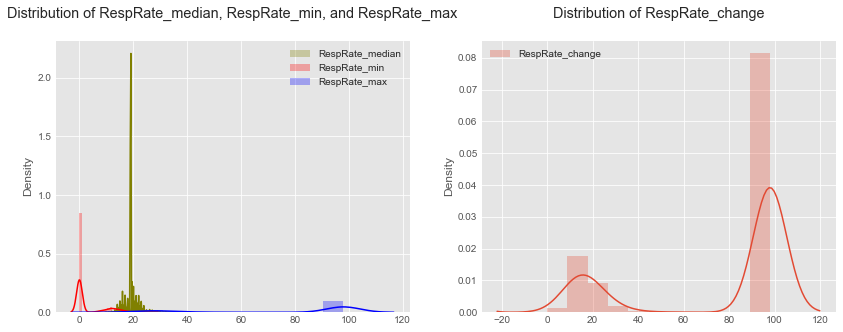

In [69]:
#Extract RespRate (respiration rate in bpm) levels and plot distributions of extracted values
respm=ts.filter(regex='RespRate')

#row-wise (patient-wise) values for median, min, max
resp = respm.T.describe().T

resp = resp[["50%", "min", "max"]]
resp.columns = ["resp_median", "resp_min", "resp_max"]

resp = resp.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
resp = median_impute_values(resp, "resp_median")
resp = min_impute_values(resp, "resp_min")
resp = max_impute_values(resp, "resp_max")

resp["resp_change"] = resp["resp_max"] - resp["resp_min"]

#plot
norm_hist_plotter(resp["resp_median"], resp["resp_min"], resp["resp_max"],resp["resp_change"],"RespRate_median","RespRate_min", "RespRate_max", "RespRate_change") 

**3.30: SaO2 feature extraction**

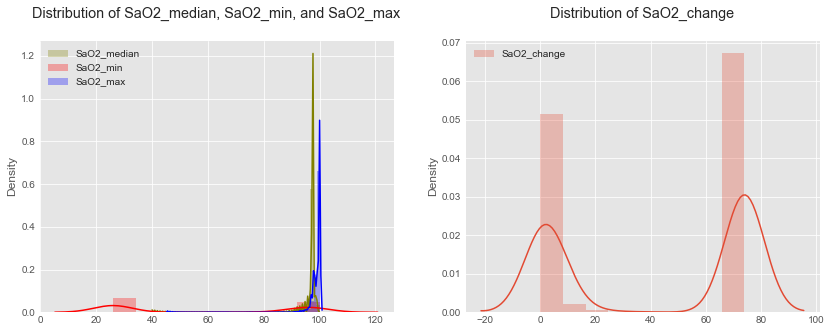

In [70]:
#Extract SaO2 (O2 saturation in hemoglobin in %) levels and plot distributions of extracted values
saom=ts.filter(regex='SaO2')

#row-wise (patient-wise) values for median, min, max
sao = saom.T.describe().T

sao = sao[["50%", "min", "max"]]
sao.columns = ["sao_median", "sao_min", "sao_max"]

sao = sao.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
sao = median_impute_values(sao, "sao_median")
sao = min_impute_values(sao, "sao_min")
sao = max_impute_values(sao, "sao_max")

sao["sao_change"] = sao["sao_max"] - sao["sao_min"]

#plot
norm_hist_plotter(sao["sao_median"], sao["sao_min"], sao["sao_max"],sao["sao_change"],"SaO2_median","SaO2_min", "SaO2_max", "SaO2_change")


**3.31: SysABP feature extraction**

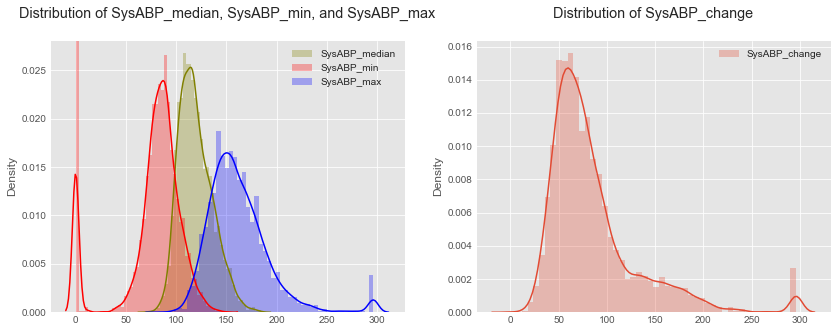

In [71]:
#Extract SysABP (Invasive systolic arterial blood pressure in mmHg units) levels and plot distributions of extracted values
sabpm=ts.filter(regex='SysABP')

#row-wise (patient-wise) values for median, min, max
sabp = sabpm.T.describe().T

sabp = sabp[["50%", "min", "max"]]
sabp.columns = ["sabp_median", "sabp_min", "sabp_max"]

sabp = sabp.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
sabp = median_impute_values(sabp, "sabp_median")
sabp = min_impute_values(sabp, "sabp_min")
sabp = max_impute_values(sabp, "sabp_max")

sabp["sabp_change"] = sabp["sabp_max"] - sabp["sabp_min"]

#plot
norm_hist_plotter(sabp["sabp_median"], sabp["sabp_min"], sabp["sabp_max"],sabp["sabp_change"],"SysABP_median","SysABP_min", "SysABP_max", "SysABP_change") 

**3.32: Temperature feature extraction**

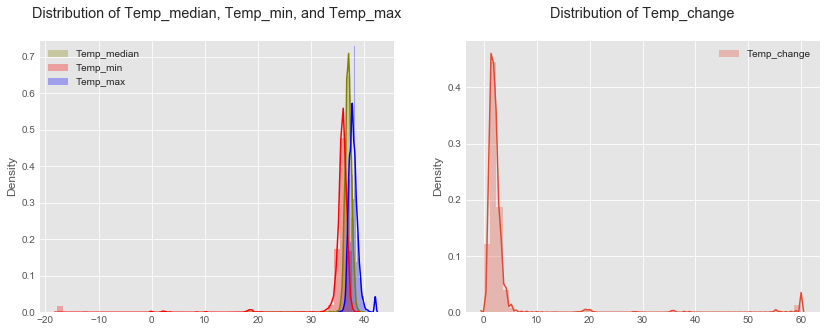

In [72]:
#Extract Temp (Temperature in degrees celsius) levels and plot distributions of extracted values
tempm=ts.filter(regex='Temp')

#row-wise (patient-wise) values for median, min, max
temp = tempm.T.describe().T

temp = temp[["50%", "min", "max"]]
temp.columns = ["temp_median", "temp_min", "temp_max"]

temp = temp.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
temp = median_impute_values(temp, "temp_median")
temp = min_impute_values(temp, "temp_min")
temp = max_impute_values(temp, "temp_max")

temp["temp_change"] = temp["temp_max"] - temp["temp_min"]

#plot
norm_hist_plotter(temp["temp_median"], temp["temp_min"], temp["temp_max"],temp["temp_change"],"Temp_median","Temp_min", "Temp_max", "Temp_change") 

Note very low temperatures in above distribution and look suspicious (especially if below zero degrees Celsius). I will evaluate further to perform outlier capping as done before (for other features).

In [73]:
temp.describe(percentiles=[0.025,0.05,0.1, 0.2, 0.5, 0.9]).T

,count,mean,std,min,2.5%,5%,10%,20%,50%,90%,max
temp_median,4000.0,37.049050,0.665571,17.85,35.900,36.1,36.3,36.6,37.05,37.8,39.8
temp_min,4000.0,34.405563,8.202753,-17.80,3.485,33.6,34.7,35.3,35.90,36.8,38.8
temp_max,4000.0,37.995550,0.907357,35.60,36.700,36.8,37.1,37.3,37.90,39.0,42.1
temp_change,4000.0,3.589987,8.646727,0.00,0.700,0.9,1.0,1.3,1.90,3.5,59.9


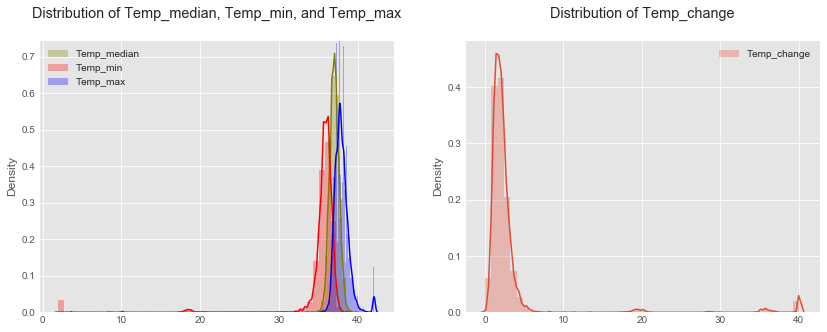

In [74]:
#outlier capping, recalculate nidia_change, and plot
temp['temp_min'] = np.where(temp['temp_min'] < 3.485, 2, temp["temp_min"])# capped at < 2.5%ile of distribution

temp["temp_change"] = temp["temp_max"] - temp["temp_min"] # recalculate temp_change

#plot
norm_hist_plotter(temp["temp_median"], temp["temp_min"], temp["temp_max"],temp["temp_change"],"Temp_median","Temp_min", "Temp_max", "Temp_change") 

Note significant increase in temperature level for a small number of patients. Patients with temperatures lower than 20 degrees C are probably entry errors. 

**3.33: Troponin I feature extraction**

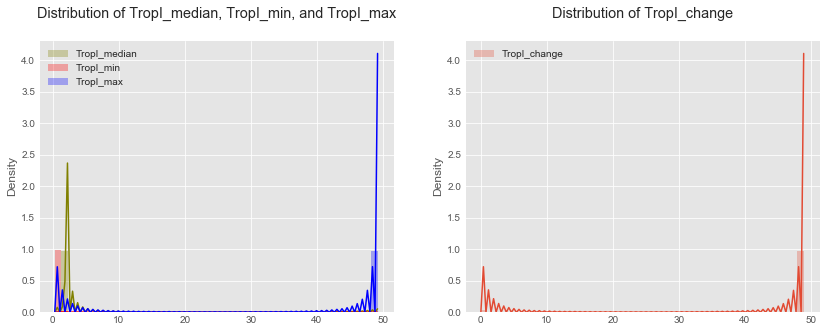

In [75]:
#Extract Troponin I levels (heart injury marker) and plot distributions of extracted values
tropim=ts.filter(regex='TroponinI')

#row-wise (patient-wise) values for median, min, max
tropi = tropim.T.describe().T

tropi = tropi[["50%", "min", "max"]]
tropi.columns = ["tropi_median", "tropi_min", "tropi_max"]

tropi = tropi.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
tropi = median_impute_values(tropi, "tropi_median")
tropi = min_impute_values(tropi, "tropi_min")
tropi = max_impute_values(tropi, "tropi_max")

tropi["tropi_change"] = tropi["tropi_max"] - tropi["tropi_min"]

#plot
norm_hist_plotter(tropi["tropi_median"], tropi["tropi_min"], tropi["tropi_max"],tropi["tropi_change"],"TropI_median","TropI_min", "TropI_max", "TropI_change") 

Note dramatic increase in Troponin I levels in many patients suggesting cardiac injury and/or recovery of Troponin I levels over time.

**3.34: Troponin T feature extraction**

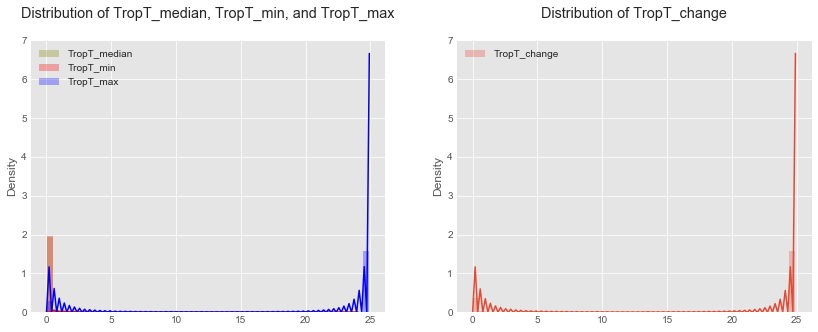

In [76]:
#Extract Troponin T levels (heart injury marker) and plot distributions of extracted values
troptm=ts.filter(regex='TroponinT')

#row-wise (patient-wise) values for median, min, max
tropt = troptm.T.describe().T

tropt = tropt[["50%", "min", "max"]]
tropt.columns = ["tropT_median", "tropT_min", "tropT_max"]

tropt = tropt.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
tropt = median_impute_values(tropt, "tropT_median")
tropt = min_impute_values(tropt, "tropT_min")
tropt = max_impute_values(tropt, "tropT_max")

tropt["tropT_change"] = tropt["tropT_max"] - tropt["tropT_min"]

#plot
norm_hist_plotter(tropt["tropT_median"], tropt["tropT_min"], tropt["tropT_max"],tropt["tropT_change"],"TropT_median","TropT_min", "TropT_max", "TropT_change") 

Note dramatic increase in Troponin T levels in many patients suggesting cardiac injury and/or recovery of Troponin T levels over time.

**3.35: Urine feature extraction**

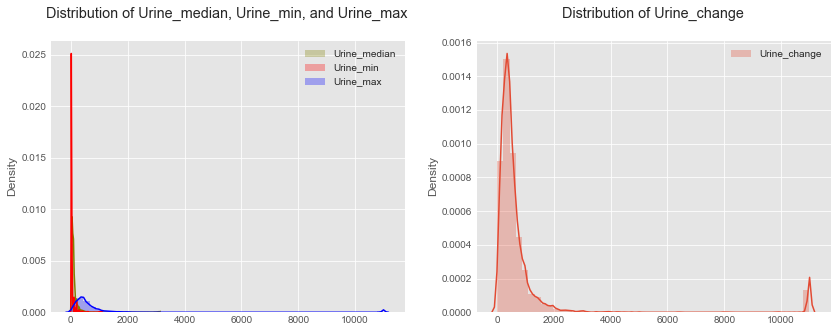

In [77]:
#Extract urine levels and plot distributions of extracted values
urinm=ts.filter(regex='Urine')

#row-wise (patient-wise) values for median, min, max
urin = urinm.T.describe().T

urin = urin[["50%", "min", "max"]]
urin.columns = ["urin_median", "urin_min", "urin_max"]

urin = urin.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
urin = median_impute_values(urin, "urin_median")
urin = min_impute_values(urin, "urin_min")
urin = max_impute_values(urin, "urin_max")

urin["urin_change"] = urin["urin_max"] - urin["urin_min"]

#plot
norm_hist_plotter(urin["urin_median"], urin["urin_min"], urin["urin_max"],urin["urin_change"],"Urine_median","Urine_min", "Urine_max", "Urine_change") 

**3.36: WBC feature extraction**

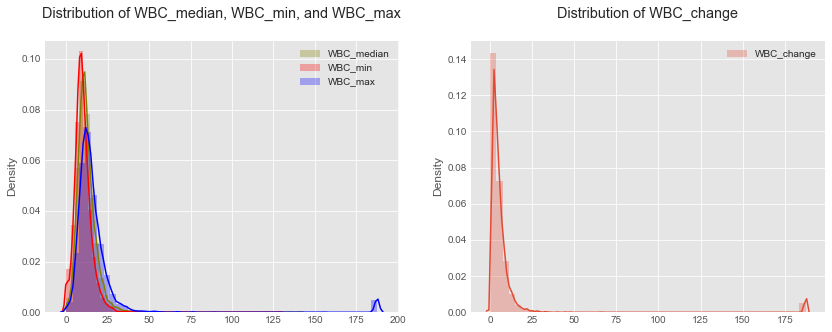

In [78]:
#Extract WBC levels (white blood cell count) and plot distributions of extracted values
wbcm=ts.filter(regex='WBC')

#row-wise (patient-wise) values for median, min, max
wbc = wbcm.T.describe().T

wbc = wbc[["50%", "min", "max"]]
wbc.columns = ["wbc_median", "wbc_min", "wbc_max"]

wbc = wbc.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
wbc = median_impute_values(wbc, "wbc_median")
wbc = min_impute_values(wbc, "wbc_min")
wbc = max_impute_values(wbc, "wbc_max")

wbc["wbc_change"] = wbc["wbc_max"] - wbc["wbc_min"]

#plot
norm_hist_plotter(wbc["wbc_median"], wbc["wbc_min"], wbc["wbc_max"],wbc["wbc_change"],"WBC_median","WBC_min", "WBC_max", "WBC_change") 

Not small fraction of patients with significant increase in WBC levels - suggesting response to infection.

**3.37: pH feature extraction**

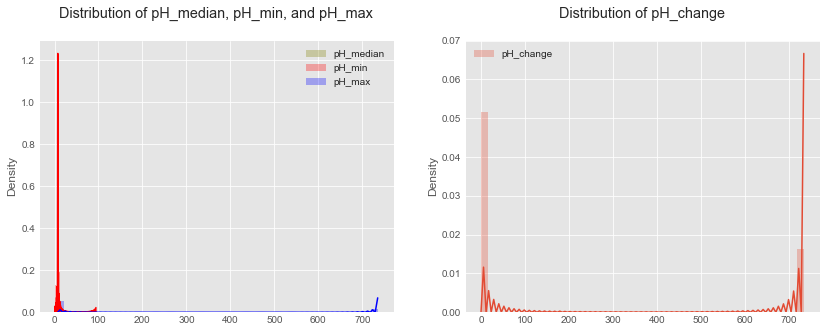

In [79]:
#Extract pH (arterial pH - measure of acidity or basicity) and plot distributions of extracted values
phm=ts.filter(regex='pH')

#row-wise (patient-wise) values for median, min, max
ph = phm.T.describe().T

ph = ph[["50%", "min", "max"]]
ph.columns = ["ph_median", "ph_min", "ph_max"]

ph = ph.fillna(-1) # fill any nan values with dummy code for imputation next

#impute and feature engineering (for change from min to max)
ph = median_impute_values(ph, "ph_median")
ph = min_impute_values(ph, "ph_min")
ph = max_impute_values(ph, "ph_max")

ph["ph_change"] = ph["ph_max"] - ph["ph_min"]

#plot
norm_hist_plotter(ph["ph_median"], ph["ph_min"], ph["ph_max"],ph["ph_change"],"pH_median","pH_min", "pH_max", "pH_change") 

Note small fraction of patients show dramatic pH change. pH level units are unusual. Will leave this as-is.

**3.38: Concatenate all extracted time-series features, inspect, and export as a csv file**

In [80]:
ts=pd.concat([weight, alp, alt, ast, alb, bun, bil, chol, creat, dia,fio, gcs, gluc, hco, hct, hr, pot, lac, mapi,
              MV.MV_count,mg, nidia, nimap, nisa, sod, paco, pao, plat, resp, sao, sabp, temp, tropi, tropt, urin, wbc, ph], 
              axis=1)

In [81]:
ts.head() #Inspect concatenated dataframe of time-series predictors

,weight_median,weight_min,weight_max,weight_range,alp_median,alp_min,alp_max,alp_change,alt_median,alt_min,...,urin_max,urin_change,wbc_median,wbc_min,wbc_max,wbc_change,ph_median,ph_min,ph_max,ph_change
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
132539,80.0,45.0,140.0,95.0,78.0,12.0,2205.0,2193.0,31.0,1.0,...,900.0,870.0,10.3,9.4,11.2,1.8,7.39,1.00,735.00,734.00
132540,80.6,76.0,81.6,5.6,78.0,12.0,2205.0,2193.0,31.0,1.0,...,770.0,770.0,13.1,7.4,13.3,5.9,7.40,7.34,7.45,0.11
132541,56.7,56.7,56.7,0.0,116.0,105.0,127.0,22.0,83.0,75.0,...,425.0,407.0,4.2,3.7,6.2,2.5,7.50,7.47,7.51,0.04
132543,84.6,84.6,84.6,0.0,105.0,105.0,105.0,0.0,12.0,12.0,...,700.0,600.0,8.8,7.9,11.5,3.6,7.39,1.00,735.00,734.00
132545,80.0,45.0,140.0,95.0,78.0,12.0,2205.0,2193.0,31.0,1.0,...,220.0,204.0,4.3,3.8,4.8,1.0,7.39,1.00,735.00,734.00


In [82]:
ts.to_csv("ts.csv") # export features extracted from time-series data
#To be merged with features extracted with time-series data (X matrix for modeling) and 
#outcome variables (Y) of interest

### 4. Assemble predictor matrix and outcome variables of interest for machine learning

For predictor matrix (X), extracted features from non-time-series data and time-series data will be combined (concatenated). 
For outcome variable/s(y), "outcomes-a" file will be imported as a csv file, outcome of interest (survive/not) will be selected, and its distribution (i.e., prevalence of each class - survived vs not) evaluated as it may need addressing during model development.

Final XY matrix, thus created, will be assembled by combining selected outcome variables and all predictors.  As the last step in this section, X matrix and Y vector will be partitioned out of XY matrix for subsequent modeling.


In [83]:
#Assemble X matrix (all predictors)
pred_x=pd.concat([ts,ntsf], axis=1) #Combine time-series predictors and non-time-series predictors
pred_x.head() #Inspect combined dataframe of all predictors

,weight_median,weight_min,weight_max,weight_range,alp_median,alp_min,alp_max,alp_change,alt_median,alt_min,...,RecordID,Height,Age,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0,Gender_0.0,Gender_1.0,Gender_missing
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
132539,80.0,45.0,140.0,95.0,78.0,12.0,2205.0,2193.0,31.0,1.0,...,132539.0,145.0,54.0,0,0,0,1,1,0,0
132540,80.6,76.0,81.6,5.6,78.0,12.0,2205.0,2193.0,31.0,1.0,...,132540.0,175.3,76.0,0,1,0,0,0,1,0
132541,56.7,56.7,56.7,0.0,116.0,105.0,127.0,22.0,83.0,75.0,...,132541.0,145.0,44.0,0,0,1,0,1,0,0
132543,84.6,84.6,84.6,0.0,105.0,105.0,105.0,0.0,12.0,12.0,...,132543.0,180.3,68.0,0,0,1,0,0,1,0
132545,80.0,45.0,140.0,95.0,78.0,12.0,2205.0,2193.0,31.0,1.0,...,132545.0,145.0,88.0,0,0,1,0,1,0,0


In [84]:
outcomes=pd.read_csv("outcomes.csv") #Read-in outcome variables as a csv file
outcomes.info()#Inspect "outcomes" dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
RecordID             4000 non-null int64
SAPS-I               4000 non-null int64
SOFA                 4000 non-null int64
Length_of_stay       4000 non-null int64
Survival             4000 non-null int64
In-hospital_death    4000 non-null int64
dtypes: int64(6)
memory usage: 187.6 KB


In [85]:
xy1=pred_x.merge(outcomes, on='RecordID')#merge predictors and outcome variables (xy matrix)

xy1.to_csv("xy1.csv", index=False) #export initial xy matrix (xy1) as a csv file

In [86]:
xy=xy1.drop(["RecordID", "SAPS-I", "SOFA", "Length_of_stay", "Survival"], axis=1) #Preserve predictor matrix with desired outcome variable
                                                #Drop non-desired outcome variables and recordID (to be not used for modeling)

In [87]:
xy.info()#Inspect xy matrix
xy.loc[:,xy.columns]=xy.loc[:,xy.columns].apply(pd.to_numeric) # convert all columns in predictor "matrix" to numeric

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 3999
Columns: 155 entries, weight_median to In-hospital_death
dtypes: float64(147), int64(1), uint8(7)
memory usage: 4.6 MB


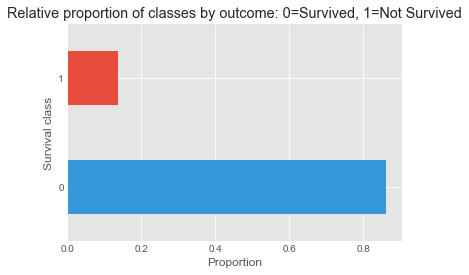

In [88]:
#plot distribution of outcome variable
flatui = ["#3498db", "#e74c3c"]#set new sns color palette
sns.set_palette(flatui)


xy["In-hospital_death"].value_counts(normalize=True).plot(kind="barh")
plt.title("Relative proportion of classes by outcome: 0=Survived, 1=Not Survived")
plt.xlabel("Proportion")
plt.ylabel("Survival class")

sns.despine()
plt.show();

In [89]:
xy["In-hospital_death"].value_counts()

0    3446
1     554
Name: In-hospital_death, dtype: int64

**Note:** Given low % of deaths in ICU, classes are imbalanced. This will be addressed using class_weights during modeling

In [90]:
y=xy["In-hospital_death"] #Declare outcome variable of interest
X=xy.drop(["In-hospital_death"], axis=1) #Declare X "matrix" by dropping outcome variable from xy dataframe

### 5. Machine learning - algorithm comparison (logistic regression vs random forest)

As an initial predictive model, Logistic Regression (as an example of a linear model) will be compared against Random Forest/RF (as an example of a non-linear model).  

Models (RF and Logistic Regression) will be compared across multiple metrics using 5-fold cross-validation with particular emphasis on: 
1. Recall/Sensitivity *(as we want to capture as many of the patients who will die)* and 
2. Precison/Positive predictive value *(as we want to have the maximum likelihood of correct death predictions for our predictions to be actionable)*.  

Based on this comparison, best model will be selected and further tweaked for performance if possible.  No variable scaling/normalization is performed for this initial comparison, but may be added subsequently to further tweak performance.

In [91]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [92]:
#Instantiate Random Forest & logistic regression classifier instances (to be used for each dataset)
rf = RandomForestClassifier(n_estimators = 500, random_state = 1, n_jobs=-1, class_weight="balanced")
log = LogisticRegression(class_weight='balanced')
    #class_weight = "balanced" used to penalize mistakes on minority (deaths in hospital) class in proportion to under-representation


In [93]:
#Function to evaluate model performance across metrics using 5-fold cross-validation
def print_accuracy_report(classifier, X, y, num_validations=5):
    auc = cross_val_score(classifier, X, y, scoring='roc_auc', cv=num_validations)
    print ("AUC (Mean->): " + str(round(100*auc.mean(), 2)) + "%" + " (Standard Deviation->): " + str(round(100*auc.std(), 2)) + "%")
    
    recall = cross_val_score(classifier, X, y, scoring='recall', cv=num_validations)
    print ("RECALL (Mean->): " + str(round(100*recall.mean(), 2)) + "%"+ " (Standard Deviation->): " + str(round(100*recall.std(), 2)) + "%")
    
    precision = cross_val_score(classifier, X, y, scoring='precision', cv=num_validations)
    print ("PRECISION (Mean->): " + str(round(100*precision.mean(), 2)) + "%"+ " (Standard Deviaton->): " + str(round(100*precision.std(), 2)) + "%")

    bal_acc = cross_val_score(classifier, X, y, scoring='balanced_accuracy', cv=num_validations)
    print ("BALANCED ACCURACY (Mean->): " + str(round(100*bal_acc.mean(), 2)) + "%"+ " (Standard Deviation->): " + str(round(100*bal_acc.std(), 2)) + "%")

In [94]:
print_accuracy_report(rf, X, y) #Evaluate Random Forest model performance out-of-the box

AUC (Mean->): 83.57% (Standard Deviation->): 0.6%
RECALL (Mean->): 3.07% (Standard Deviation->): 0.91%
PRECISION (Mean->): 77.67% (Standard Deviaton->): 16.18%
BALANCED ACCURACY (Mean->): 51.46% (Standard Deviation->): 0.47%


**Note:** *Poor Recall with out-of-the-box Random Forest algorithm*

In [95]:
print_accuracy_report(log, X, y)#Evaluate Logistic Regression model performance out-of-the box

AUC (Mean->): 81.65% (Standard Deviation->): 1.58%
RECALL (Mean->): 69.49% (Standard Deviation->): 3.63%
PRECISION (Mean->): 31.7% (Standard Deviaton->): 1.2%
BALANCED ACCURACY (Mean->): 72.7% (Standard Deviation->): 1.61%


**Note:** *Dramatically better Recall (most important metric), but lower Precision with Logistic Regression than Random Forest.  
Since Logistic Regression yields a better model with more "balanced" performance across multiple metrics, I will not use Random Forest and instead evaluate further opportunities to refine Logistic Regression model performance.*

### 6. Logistic regression model improvement

Given that Logistic Regression performed better than Random Forest, this algorithm will be evaluated further with an aim to improve it towards a "final" model in a step-wise manner as outlined below: 
- **A.** Evaluate effect of Log2 transformation of features on model performance - This can adjust skew of distributions (i.e., "normalize" them) which can improve performance in linear models by allevating homoscedasticity of errors caused by skewed distributions<br>
- **B.** Evaluating L1 regularization strengths for model refinement/feature reduction <br>
- **C.** Build L1 model using optimal L1 regularization strength and calculate odds-ratios for features in this model<br>
- **D.** Select Top features from L1 regularized model for "final" model. Compare performance of L1 model vs "final" model via cross-validation.<br>
- **E.** Generate odds-ratios for all features in final model and visualize distributions of most important predictors in survived vs non-survived
- **F.** Generate representative ROC chart and precision-recall vs threshold chart(s) on final model<br>


**6A. Evaluate effect of log2 transformation on model performance**

In [96]:
#6A. Log2 transformation and evaluating effect on logistic regression model

# Scale X matrix to a 0-1 scale and add a tiny constant to all features (to ensure all values are positive for log2 transform)
from sklearn.preprocessing import MinMaxScaler # Min-max (0-1) scaling
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

X_scaled += 0.000000001 # Adding a constant to all features (to ensure no zeros exist for enabling log2 transformation)

#log2 transformation
X_lt = np.log2(X_scaled)

#Evaluate effect of log2 transformation on logistic regression model
print_accuracy_report(log, X_lt, y)

AUC (Mean->): 78.5% (Standard Deviation->): 0.98%
RECALL (Mean->): 68.95% (Standard Deviation->): 3.6%
PRECISION (Mean->): 30.9% (Standard Deviaton->): 1.82%
BALANCED ACCURACY (Mean->): 72.04% (Standard Deviation->): 1.86%


**Note** - No apparent benefit of using log2 transformation on model performance (compared to non-transformed features in Section 5). Hence, log2 transformed features will not be used. 

**6B. Evaluate L1 regularization strengths for model refinement/feature reduction**

In [97]:
#Generate test-train split and evaluate L1 regularization strength for final/L1 model development
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X_scaled,y, stratify=y, test_size=0.3, random_state=2)

#Evaluate L1 regularization strengths for reducing features in final model
C = [10, 1, .1, 0.05,.01,.001] # As C decreases, more coefficients go to zero

for c in C:
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear', class_weight="balanced")
    clf.fit(train_x, train_y)
    pred_y=clf.predict(test_x) 
    print("Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE: ", c)
    cr=metrics.classification_report(test_y, pred_y)
    print(cr)
    print('')

Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE:  10
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1034
           1       0.31      0.72      0.44       166

   micro avg       0.74      0.74      0.74      1200
   macro avg       0.63      0.73      0.64      1200
weighted avg       0.86      0.74      0.78      1200


Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE:  1
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1034
           1       0.34      0.79      0.47       166

   micro avg       0.76      0.76      0.76      1200
   macro avg       0.65      0.77      0.66      1200
weighted avg       0.87      0.76      0.79      1200


Model performance with Inverse Regularization Parameteter, C = 1/λ VALUE:  0.1
              precision    recall  f1-score   support

           0       0.96      0.74      0.83      1034
 

**Note**- *Above evaluation of L1 regularization strengths demonstrate that C can be lowered till 0.1 (for lowering model complexity) without affecting model performance significantly but values of C<0.1 will affect model performance negatively.  Therefore, Set C=0.1 for final logistic regression model*

**6C. Build L1 model and calculate odds-ratios of features within L1 model**

In [98]:
#Develop L1 Logistic Regression Model and evaluate performance using cross-validation
logl1=LogisticRegression(penalty='l1', C=0.1, solver='liblinear', class_weight="balanced")

print_accuracy_report(logl1, X, y) #Performance evaluation of L1 regularized logistic regression model

AUC (Mean->): 81.73% (Standard Deviation->): 1.73%
RECALL (Mean->): 69.67% (Standard Deviation->): 4.86%
PRECISION (Mean->): 31.53% (Standard Deviaton->): 1.7%
BALANCED ACCURACY (Mean->): 72.71% (Standard Deviation->): 2.3%


**Note**- *L1 model performance is comparable to that of initial model generated in Section 5*

In [99]:
#Generate an L1 refined logistic regression model and list of features with coefficients/odds-ratios
logl1.fit(train_x, train_y)
pred_y=logl1.predict(test_x) 
probs_y=logl1.predict_proba(test_x)  

#Construct a dataframe of all features with their coefficients/odds-ratios from L1 model(logf)
coeff = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(logl1.coef_))], axis = 1)
coeff.columns=("features", "coefficients")
coeff["odds_ratio"]=np.exp(coeff.coefficients)

In [100]:
#Select all features with non-zero odds-ratios
L1_feat=coeff[coeff["coefficients"] != 0] .sort_values("odds_ratio", ascending=False)
L1_feat.to_csv("L1_features.csv", index=False)  #Export features with their coefficients/odds-ratios to a csv file

**Note**- *L1 model includes 28 features compared to initial model in Section 5 with > 150 features. Next, I evaluate if the number of features can be tweaked further via their odds-ratios in the L1 model*

**6D. Build "final" model after evaluate ability to refine L1 model via selection of "top" features from L1 model**

In [101]:
#6D.1. Further refine final model by removing all features with odds-ratios between 1.25 and 0.8 (selected from L1_feat)
selected_features=["bun_min", "gcs_median","Age","bil_median", "fio_median","ICUType_2.0", "gcs_change",
                         "resp_max","hr_max","gcs_max","ICUType_3.0","tropi_change","temp_max","weight_max",
                        "nidia_min","alt_change","weight_min","dia_min"]

X_top18=X[selected_features] #Subset top18 features into a new preditor matrix

print_accuracy_report(logl1, X_top18, y) #Evaluate performance using subsetted top18 predictors (compared to 28 L1 predictors in Sectio 6C)

AUC (Mean->): 82.7% (Standard Deviation->): 0.98%
RECALL (Mean->): 76.18% (Standard Deviation->): 3.95%
PRECISION (Mean->): 32.24% (Standard Deviaton->): 0.49%
BALANCED ACCURACY (Mean->): 75.2% (Standard Deviation->): 1.18%


**Note** - *By comparing model performance metrics for top 18 features (see immediately above) vs L1 regularized features (see Section 6C), it is apparent that using top 18 features yields a better performing model across multiple metrics - including recall (most important metric for this study)*

In [102]:
#6D.2. Build "final" model based on top18 features from above and L1 regularization

X_scaled18 = min_max_scaler.fit_transform(X_top18)#Scale features

train_x18, test_x18, train_y, test_y = train_test_split(X_scaled18,y, stratify=y, test_size=0.3, random_state=2) #Generate a test-train split of data for model training and testing

logl1.fit(train_x18, train_y) #fit final model 

pred_y18 = logl1.predict(test_x18) #store final model predictions 
probs_y18 = logl1.predict_proba(test_x18) #final model class probabilities 

**6E.1.** *Generate odds-ratios for all features in final model and plot*

In [103]:
#Construct a dataframe of all features with their coefficients/odds-ratios from "final" model
coeff_final = pd.concat([pd.DataFrame(X_top18.columns),pd.DataFrame(np.transpose(logl1.coef_))], axis = 1)
coeff_final.columns=("features", "coefficients")
coeff_final["odds_ratio"]=np.exp(coeff_final.coefficients)

In [104]:
coeff_final.head()

,features,coefficients,odds_ratio
0,bun_min,3.188618,24.254889
1,gcs_median,-1.770974,0.170167
2,Age,1.560426,4.760847
3,bil_median,0.973368,2.646844
4,fio_median,0.920881,2.511501


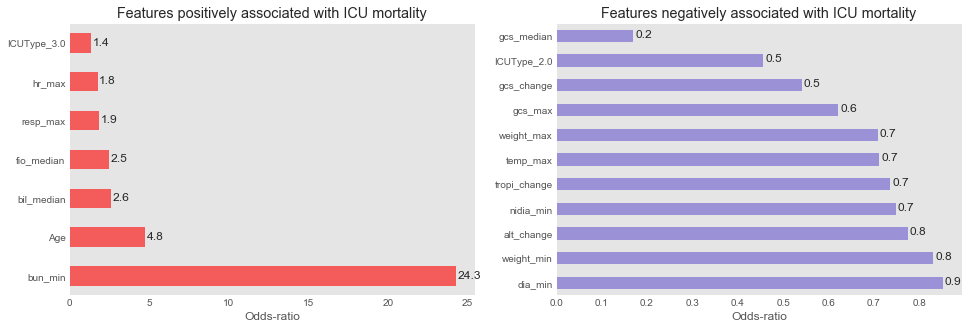

In [105]:
#Generate dataframes of features with positive vs negative odds-ratios and plot
coeff_final.sort_values("odds_ratio", ascending=False)

coeff_pos=coeff_final[coeff_final["odds_ratio"]>1] #Generate dataframe of "positive" predictors 
coeff_pos_=coeff_pos.sort_values("odds_ratio", ascending=True)

coeff_neg=coeff_final[coeff_final["odds_ratio"]<=1]  #Generate dataframe of "negative" predictors of mortality
coeff_neg=coeff_neg.sort_values("odds_ratio", ascending=False)

#plot
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(16,5))
sns.set_style("white")

coeff_pos.plot(x="features", y="odds_ratio", kind="barh", legend=False, ax=ax1,color="red", alpha=0.6)
ax1.set_xlabel("Odds-ratio")
ax1.set_ylabel("")
ax1.set_title("Features positively associated with ICU mortality")
for i in ax1.patches:
    ax1.text(i.get_width()+.1, i.get_y()+.2,str(round((i.get_width()), 1)), fontsize=12)# attach values next to each bar in bar chart



coeff_neg.plot(x="features", y="odds_ratio", kind="barh", legend=False, ax=ax2, color="slateblue", alpha=0.6)
ax2.set_xlabel("Odds-ratio")
ax2.set_ylabel("")
ax2.set_title("Features negatively associated with ICU mortality")
for i in ax2.patches:
    ax2.text(i.get_width()+.005, i.get_y()+.2,str(round((i.get_width()), 1)), fontsize=12) # attach values next to each bar in bar chart

sns.despine()
plt.show();

**Note** - above odds-ratios are using predictors scaled between 0-1.  Thus, they reflect the change in odds of mortality with increase of feature from min to max (which corresponds to unit increase given variables are scaled). 

Most important predictors* (at least 1.5-fold change in odds of outcome)* of mortality are: 
- Blood Urea Nitrogen (bun_min)
- Age
- Bilirubin (bil_median) 
- Fraction of Inspired Oxygen (fio_median) 
- Respiratory rate (resp_max)
- Pulse rate (hr_max) 
- ICU_type_3.0 and
- Gleason coma score (gcs_median, gcs_change, gcs_max)

Next, distribution of numeric features(excludes ICU_type_3.0 - a categorical feature) will be visualized in survivors vs non-survivors, to evaluate their individual ability to discriminate patient class (survived vs non-survivor).

**6E.2. Visualize distributions of most important predictors in survived vs non-survived classes of patients**

In [106]:
#combine dataframe to include top features
imp_feat=pd.concat([bun,bil,nts,fio,resp,hr,gcs], axis=1)

imp_feat_y=imp_feat.merge(outcomes, on='RecordID')

imp_feat_y = imp_feat_y[['bun_min','bil_median','Age','bil_median', 'fio_median','resp_max', 
                         'hr_max','gcs_median','gcs_change', 'gcs_max','In-hospital_death']]

In [107]:
#mn-max scaling of predictors (to allow for side-by-side comparison of all features on same graph)
imp_feat = imp_feat_y.drop('In-hospital_death', axis = 1)
imp_feat_scaled  = (imp_feat - imp_feat.min()) / (imp_feat.max() - imp_feat.min())

In [108]:
#Concatenate predictors with outcome variable
if_y_scaled = pd.concat([imp_feat_scaled, imp_feat_y['In-hospital_death']], axis=1)

if_y_scaled["In-hospital_death"] = np.where(if_y_scaled["In-hospital_death"] == 0, "Survivors", "Non-survivors")

In [109]:
#Convert dataframe to tidy format
tidy_if_y_scaled=if_y_scaled.melt(id_vars=["In-hospital_death"], 
                           value_vars=['bun_min','bil_median','Age','bil_median', 'fio_median',
                                     'resp_max', 'hr_max','gcs_median','gcs_change', 'gcs_max'])

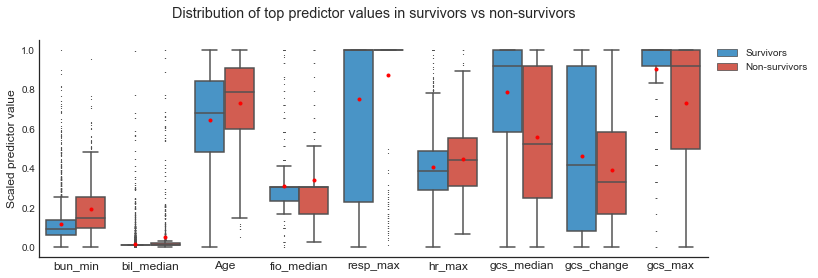

In [110]:
#Plot
flatui = ["#3498db", "#e74c3c"] #set new sns color palette
sns.set_palette(flatui)
sns.set_style("white")

fig, ax = plt.subplots(figsize=(12, 4))
flierprops = dict(markerfacecolor='.05', markersize=.3,linestyle='none') #Adjust appearance of outliers (size/color) 
ax=sns.boxplot(x = "variable", y="value", data = tidy_if_y_scaled,
               showmeans=True, meanprops={"marker":".","markerfacecolor":"red", "markeredgecolor":"red"},
               hue="In-hospital_death", flierprops=flierprops)
              #boxprops=dict(alpha=.9))
ax.set_xlabel("")
ax.set_ylabel("Scaled predictor value")
ax.set_title("Distribution of top predictor values in survivors vs non-survivors\n")
ax.legend(loc='top left',bbox_to_anchor=(1, 1))
plt.xticks(size = 12)
sns.despine()
plt.show();



**Note:**
- Features positively associated with mortality tend to have higher means/values in non-survivors (except perhaps fio_median)
- Features negatively associated with mortality tend to have lower means/values in non-survivors (gcs_median, gcs_change, gcs_max)

**6F. ROC and precision-recall vs threshold curves for "final" model (multiple test-train splits)**

In [111]:
from sklearn.model_selection import StratifiedKFold

skf=StratifiedKFold(n_splits=5, shuffle = True, random_state = 999)


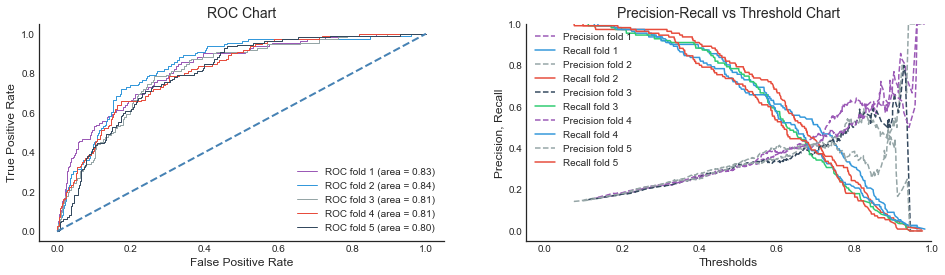

In [112]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # set 5-color sns palette
sns.set_palette(flatui)
sns.set_style("white")

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121) # Plot ROC curve across multiple test-train splits

for i, (train_index, test_index) in enumerate(skf.split(X_scaled18,y)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(X_scaled18[train_index], y[train_index]).predict_proba(X_scaled18[test_index])
    #Compute ROC curve for each test_train split
    fpr, tpr, thresholds = metrics.roc_curve(y[test_index], probas_[:,1])
    #Compute AUC for each test_train split
    roc_auc = metrics.auc(fpr, tpr)
    #Plot and add legend/title
    plt.plot(fpr, tpr, lw=1, label = "ROC fold %d (area = %0.2f)" % (i+1, roc_auc))
    plt.legend(loc='lower right')
    plt.title("ROC Chart", size = 14)
    
    
plt.plot([0,1], [0,1],'--',  lw = 2, color = "steelblue") # line for "random" guesses 

#Set graph axes, labels
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


axes = fig.add_subplot(122) # PLot Precision-Recall vs. (Probability) Threshold curve across multiple test-train splits

for i, (train_index, test_index) in enumerate(skf.split(X_scaled18,y)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(X_scaled18[train_index], y[train_index]).predict_proba(X_scaled18[test_index])
    #Compute precision-recall curves for each test_train split 
    precision, recall, thresholds = metrics.precision_recall_curve(y[test_index], probas_[:,1]) #retrieve probability of being 1(in second column of probs_y)
    #Compute area under curve for each test_train split
    pr_auc = metrics.auc(recall, precision)
    #Plot and add legend/title
    plt.plot(thresholds, precision[: -1], "--", label = "Precision fold %d " % (i+1))
    plt.plot(thresholds, recall[: -1] ,"-", label = "Recall fold %d " % (i+1))
    
    plt.legend(loc='left')
    
    plt.title("Precision-Recall vs Threshold Chart", size = 14)

#Set graph axes, labels
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.0])

plt.ylabel("Precision, Recall")
plt.xlabel("Thresholds")

sns.despine()
plt.show();

**Note**- ROC chart shows very consistent performance across test-train splits.  Precision-Recall vs Threshold chart shows Recall is very consistent but Precision is variable at higher probability thresholds across various test-train combinations. 
Precision is very consistent at probability thresholds < 0.5. 


**General comments on possible ways to improve model**- From above views of ROC chart and Precision-Recall vs Threshold charts, it is evident that lowering the probability thresholds can increase sensitivity (at the cost of increasing false positives and reducing precision). Lowering probability thresholds to ~0.4 will increase sensitivity to 0.8 - 0.9 from existing perrformance (0.76 recall average).Thus, this is one option to increase model performance for sensitivity. 

Also, one might be able to look for additional features that might influence mortality risk in general (eg: pre-existing conditions, hospital stay duration etc) to increase overall model performance.

### 7. Comparison of above model to current benchmarks

As a final section in this notebook, the model developed above using 18 predictors will be compared to the performance of the model using SAPS-1 and SOFA-scores (present in xy1.csv). 

Thus, a model will be generated using the 18 predictors alone vs 18 predictors + SAPS-1 and SOFA-scores and a model with SAPS-1 and SOFA-scores alone.  

In [113]:
xy1.head()

,weight_median,weight_min,weight_max,weight_range,alp_median,alp_min,alp_max,alp_change,alt_median,alt_min,...,ICUType_3.0,ICUType_4.0,Gender_0.0,Gender_1.0,Gender_missing,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,80.0,45.0,140.0,95.0,78.0,12.0,2205.0,2193.0,31.0,1.0,...,0,1,1,0,0,6,1,5,-1,0
1,80.6,76.0,81.6,5.6,78.0,12.0,2205.0,2193.0,31.0,1.0,...,0,0,0,1,0,16,8,8,-1,0
2,56.7,56.7,56.7,0.0,116.0,105.0,127.0,22.0,83.0,75.0,...,1,0,1,0,0,21,11,19,-1,0
3,84.6,84.6,84.6,0.0,105.0,105.0,105.0,0.0,12.0,12.0,...,1,0,0,1,0,7,1,9,575,0
4,80.0,45.0,140.0,95.0,78.0,12.0,2205.0,2193.0,31.0,1.0,...,1,0,1,0,0,17,2,4,918,0


In [127]:
##Current model predictors
top18=["bun_min", "gcs_median","Age","bil_median", "fio_median","ICUType_2.0", "gcs_change",
                         "resp_max","hr_max","gcs_max","ICUType_3.0","tropi_change","temp_max","weight_max",
                        "nidia_min","alt_change","weight_min","dia_min"]

X_top18=xy1[top18] #Subset top18 features into a new preditor matrix

X_top18_scaled = min_max_scaler.fit_transform(X_top18) #min-max scale predictors


##SOFA and SAPS-1 score model predictors (current predictors/benchmark)
ss=["SAPS-I", "SOFA"]
X_ss=xy1[ss]
X_ss_scaled = min_max_scaler.fit_transform(X_ss)


##Current model predictors + benchmark predictors
cmbp = ["bun_min", "gcs_median","Age","bil_median", "fio_median","ICUType_2.0", "gcs_change",
                         "resp_max","hr_max","gcs_max","ICUType_3.0","tropi_change","temp_max","weight_max",
                        "nidia_min","alt_change","weight_min","dia_min", "SAPS-I", "SOFA"]

X_cmbp=xy1[cmbp]
X_cmbp_scaled = min_max_scaler.fit_transform(X_cmbp)

##Adding length of stay as yet another predictor

top18_LOS=["bun_min", "gcs_median","Age","bil_median", "fio_median","ICUType_2.0", "gcs_change",
                         "resp_max","hr_max","gcs_max","ICUType_3.0","tropi_change","temp_max","weight_max",
                        "nidia_min","alt_change","weight_min","dia_min", "Length_of_stay"]

X_top18LOS=xy1[top18_LOS] #Subset top18 features into a new preditor matrix

X_top18LOS_scaled = min_max_scaler.fit_transform(X_top18LOS) #min-max scale predictors


In [128]:
print("Current logistic regression model with top 18 predictors")
print_accuracy_report(logl1, X_top18_scaled, y)
print("\n")

print("Logistic regression model with SOFA and SAPS-1 scores")
print_accuracy_report(logl1, X_ss_scaled, y)
print("\n")

print("Combined logistic regression model with top18 predictors and SAPS-1/SOFA scores")
print_accuracy_report(logl1, X_cmbp_scaled, y)
print("\n")

print("Combined logistic regression model with top18 predictors and Length of Stay")
print_accuracy_report(logl1, X_top18LOS_scaled, y)
print("\n")


Current logistic regression model with top 18 predictors
AUC (Mean->): 82.08% (Standard Deviation->): 0.74%
RECALL (Mean->): 74.91% (Standard Deviation->): 3.42%
PRECISION (Mean->): 31.19% (Standard Deviaton->): 0.65%
BALANCED ACCURACY (Mean->): 74.16% (Standard Deviation->): 1.19%


Logistic regression model with SOFA and SAPS-1 scores
AUC (Mean->): 63.92% (Standard Deviation->): 2.96%
RECALL (Mean->): 60.09% (Standard Deviation->): 7.13%
PRECISION (Mean->): 18.33% (Standard Deviaton->): 1.83%
BALANCED ACCURACY (Mean->): 58.54% (Standard Deviation->): 3.57%


Combined logistic regression model with top18 predictors and SAPS-1/SOFA scores
AUC (Mean->): 82.05% (Standard Deviation->): 0.71%
RECALL (Mean->): 75.09% (Standard Deviation->): 3.32%
PRECISION (Mean->): 31.34% (Standard Deviaton->): 0.65%
BALANCED ACCURACY (Mean->): 74.31% (Standard Deviation->): 1.14%


Combined logistic regression model with top18 predictors and Length of Stay
AUC (Mean->): 82.08% (Standard Deviation->): 0.74

**Conclusions**: 
- The "final" model developed in this notebook (logistic regression) using top 18 features performs better than a logistic regression model based on SOFA and SAPS-1 scores. 
- Incorporation of SAPS-I/SOFA scores OR length of stay do not improve performance of "final" model.  
- Thus, there is value in using the top18 features identified here to develop a model for predicting hospital mortality of ICU patients. 

To compare model performance visually, ROC charts plotted for "final" model vs "benchmark" model.

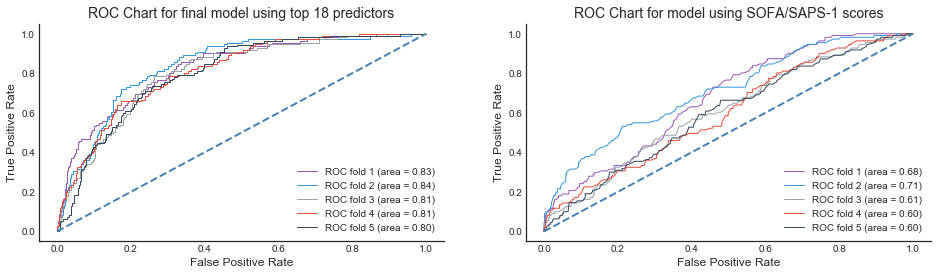

In [123]:
#ROC chart comparison of "final" model in this study vs a logistic regression model using SAPS-I and SOFA scores used as a benchmark

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # set 5-color sns palette
sns.set_palette(flatui)
sns.set_style("white")

fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(16)

axes = fig.add_subplot(121) # Plot ROC curve across multiple test-train splits

for i, (train_index, test_index) in enumerate(skf.split(X_scaled18,y)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(X_scaled18[train_index], y[train_index]).predict_proba(X_scaled18[test_index])
    #Compute ROC curve for each test_train split
    fpr, tpr, thresholds = metrics.roc_curve(y[test_index], probas_[:,1])
    #Compute AUC for each test_train split
    roc_auc = metrics.auc(fpr, tpr)
    #Plot and add legend/title
    plt.plot(fpr, tpr, lw=1, label = "ROC fold %d (area = %0.2f)" % (i+1, roc_auc))
    plt.legend(loc='lower right')
    plt.title("ROC Chart for final model using top 18 predictors", size = 14)
    
    
plt.plot([0,1], [0,1],'--',  lw = 2, color = "steelblue") # line for "random" guesses 

#Set graph axes, labels
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


axes = fig.add_subplot(122) # PLot ROC cuve across multiple test-train splits using SAPS-1 and SOFA scores

for i, (train_index, test_index) in enumerate(skf.split(X_ss_scaled,y)):
    #Calculate probability of each class from each test_train split
    probas_ = logl1.fit(X_ss_scaled[train_index], y[train_index]).predict_proba(X_ss_scaled[test_index])
    #Compute ROC curve for each test_train split
    fpr, tpr, thresholds = metrics.roc_curve(y[test_index], probas_[:,1])
    #Compute AUC for each test_train split
    roc_auc = metrics.auc(fpr, tpr)
    #Plot and add legend/title
    plt.plot(fpr, tpr, lw=1, label = "ROC fold %d (area = %0.2f)" % (i+1, roc_auc))
    plt.legend(loc='lower right')
    plt.title("ROC Chart for model using SOFA/SAPS-1 scores", size = 14)

plt.plot([0,1], [0,1],'--',  lw = 2, color = "steelblue") # line for "random" guesses 

#Set graph axes, labels
plt.xlim([-0.05, 1.05]) 
plt.ylim([-0.05, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


sns.despine()
plt.show();

**Conclusions**: Current model (logistic regression) using top 18 features performs better than a logistic regression model based on SOFA and SAPS-1 scores. 

--THE END--